# Complete classes analysis
### This notebook shows the results if we ignore all cases with any complete classes during evaluation
In this case that only applues to the AMOM, KiTS and BraTS datasets
Dataset was generate with generate_complete_datasets.py

Best validation DSC epoch is used as the model and the new loss function, which ignores calibration for empty GT classes is used

In [50]:
import os
import pandas as pd
import argparse
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
import matplotlib.lines as mlines

In [51]:

# Per case metrics:
TEST_METRICS_CSVS = {
    "micro_ACE": "micro_ace_raw.csv",
    "macro_ACE": "macro_ace_raw.csv",
    "micro_ECE": "micro_ece_raw.csv",
    "macro_ECE": "macro_ece_raw.csv",
    "micro_MCE": "micro_mce_raw.csv",
    "macro_MCE": "macro_mce_raw.csv",
    "DSC": "mean_dice_raw.csv",
}  # Columns are "filename", "class0", "class1", "class2, ..., mean"

# Metrics summary:
TEST_METRICS_CSVS_SUMMARY = {
    "micro_ACE": "micro_ace_summary.csv",
    "macro_ACE": "macro_ace_summary.csv",
    "micro_ECE": "micro_ece_summary.csv",
    "macro_ECE": "macro_ece_summary.csv",
    "micro_MCE": "micro_mce_summary.csv",
    "macro_MCE": "macro_mce_summary.csv",
    "DSC": "mean_dice_summary.csv",
}

In [52]:
# Runs for the new loss function - loss function sets 0 calibration error for empty GT classes
RUNS = {
    "amos": {
        "baseline": "bundles/amos22_baseline_dice_ce_nl",
        "hardl1ace": "bundles/amos22_hardl1ace_dice_ce_nl",
        "softl1ace": "bundles/amos22_softl1ace_dice_ce_nl",
    },
    "acdc": {
        "baseline": "bundles/acdc17_baseline_dice_ce_1",
        "hardl1ace": "bundles/acdc17_hardl1ace_dice_ce_1",
        "softl1ace": "bundles/acdc17_softl1ace_dice_ce_1",
    },
    "kits": {
        "baseline": "bundles/kits23_baseline_dice_ce_nl",
        "hardl1ace": "bundles/kits23_hardl1ace_dice_ce_nl",
        "softl1ace": "bundles/kits23_softl1ace_dice_ce_nl",
    },
    "brats": {
        "baseline": "bundles/brats21_baseline_dice_ce_nl",
        "hardl1ace": "bundles/brats21_hardl1ace_dice_ce_nl",
        "softl1ace": "bundles/brats21_softl1ace_dice_ce_nl",
    },
}

SEED = 12345

In [53]:
def load_csv_files(run, no_HEC = False):
    dataframes = {}
    for metric, csv_file in {**TEST_METRICS_CSVS, **TEST_METRICS_CSVS_SUMMARY}.items():
        if no_HEC:
            csv_path = os.path.join(run, f'seed_{SEED}', "inference_results_complete_cases_only_no_HEC", csv_file)  # These don't exist at present
        else:
            csv_path = os.path.join(run, f'seed_{SEED}', "inference_results_complete_cases_only", csv_file)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            metric_type = "summary" if metric in TEST_METRICS_CSVS_SUMMARY else "raw"
            dataframes[metric] = {metric_type: df}
        else:
            warnings.warn(f"File does not exist: {csv_path}")
    return dataframes


def load_results(runs, no_HEC = False):
    results = {}
    for key in runs:
        results[key] = {}
        for run_key, run in runs[key].items():
            results[key][run_key] = load_csv_files(run, no_HEC)
            print(f"Loaded {key} {run_key}")
    return results


def create_combined_dsc_ace_table(results, avg_type="micro"):
    def get_metrics(dataframes, dataset_key, run_key, metric):
        try:
            df = dataframes[dataset_key][run_key][metric]["summary"]
            mean = df[df["class"] == "mean"]["mean"].values[0]
            std = df[df["class"] == "mean"]["std"].values[0]
            return mean, std
        except KeyError:
            return None, None

    table_data = []
    for loss_function, run_key in zip(
        ["Baseline", "Hard L1-ACE", "Soft L1-ACE"],
        ["baseline", "hardl1ace", "softl1ace"],
    ):
        row = [loss_function]
        for dataset in ["acdc", "amos", "kits", "brats"]:
            dsc_mean, dsc_std = get_metrics(results, dataset, run_key, "DSC")
            ace_mean, ace_std = get_metrics(results, dataset, run_key, f"{avg_type}_ACE")
            if dsc_mean is not None and ace_mean is not None:
                row.append(f"{dsc_mean:.3f} ± {dsc_std:.3f}")
                row.append(f"{ace_mean:.3f} ± {ace_std:.3f}")
            else:
                row.append("N/A")
                row.append("N/A")
        table_data.append(row)

    headers = [
        "Loss Function",
        "ACDC 17 DSC",
        f"ACDC 17 {avg_type.upper()} ACE",
        "AMOS 22 DSC",
        f"AMOS 22 {avg_type.upper()} ACE",
        "KiTS 23 DSC",
        f"KiTS 23 {avg_type.upper()} ACE",
        "BraTS 21 DSC",
        f"BraTS 21 {avg_type.upper()} ACE",
    ]
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))

    # latex_code = "\n".join(
    #     [
    #         "\\begin{table*}[t]",
    #         "\\centering",
    #         f"\\caption{{Performance (DSC) and Calibration ({avg_type.upper()} ACE) Metrics for Different Loss Functions and Datasets}}",
    #         "\\label{tab:dsc_ace}",
    #         "\\begin{tabular}{lcccccccc}",
    #         "\\hline",
    #         "\\multirow{2}{*}{\\textbf{Loss Function}} & \\multicolumn{2}{c}{\\textbf{ACDC 17}} & \\multicolumn{2}{c}{\\textbf{AMOS 22}} & \\multicolumn{2}{c}{\\textbf{KiTS 23}} & \\multicolumn{2}{c}{\\textbf{BraTS 21}} \\\\",
    #         "& \\textbf{DSC} & \\textbf{ACE} & \\textbf{DSC} & \\textbf{ACE} & \\textbf{DSC} & \\textbf{ACE} & \\textbf{DSC} & \\textbf{ACE} \\\\",
    #         "\\hline",
    #     ]
    # )
    # for row in table_data:
    #     latex_code += " " + " & ".join(row) + " \\\n"
    # latex_code += "\\hline\n\\end{tabular}\n\\end{table*}"
    # print(latex_code)
            

def create_spider_plot(results, avg_type="micro", save_fig=False):
    metrics = ["ACE", "ECE", "MCE", "DSC"]
    datasets = ["amos", "acdc", "kits", "brats"]
    loss_functions = ["baseline", "hardl1ace", "softl1ace"]
    output_dir = "radar_plots_complete_classes"
    os.makedirs(output_dir, exist_ok=True)

    for dataset in datasets:
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]

        baseline_values = []
        for metric in metrics:
            metric_key = f"{avg_type}_{metric}" if metric != "DSC" else metric
            try:
                df = results[dataset]["baseline"][metric_key]["summary"]
                mean = df[df["class"] == "mean"]["mean"].values[0]
                baseline_values.append(mean)
            except KeyError:
                baseline_values.append(1)

        for loss_function in loss_functions:
            values = []
            for metric, baseline in zip(metrics, baseline_values):
                metric_key = f"{avg_type}_{metric}" if metric != "DSC" else metric
                try:
                    df = results[dataset][loss_function][metric_key]["summary"]
                    mean = df[df["class"] == "mean"]["mean"].values[0]
                    normalized_value = mean / baseline if baseline != 0 else 0
                    values.append(normalized_value)
                except KeyError:
                    values.append(0)
            values += values[:1]
            ax.plot(angles, values, linewidth=2, linestyle="solid", label=loss_function)
            ax.fill(angles, values, alpha=0.15)

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        plt.xticks(angles[:-1], metrics, fontsize=20)  # Increase font size of axis labels
        ax.set_rlabel_position(0)
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color="black", size=20)
        plt.ylim(0, 1.1)

        # plt.title(
        #     f"Normalized Spider Plot for {dataset.upper()} Dataset ({avg_type.upper()})",
        #     size=20,
        #     color="black",
        #     y=1.1,
        # )
        # plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
        
        print(f"Normalized Spider Plot for {dataset.upper()} Dataset ({avg_type.upper()})")

        if save_fig:
            pdf_filename = os.path.join(output_dir, f"normalized_spider_plot_{dataset}_{avg_type}.pdf")
            plt.savefig(pdf_filename, format="pdf")
        plt.show()


results = load_results(RUNS)

Loaded amos baseline
Loaded amos hardl1ace
Loaded amos softl1ace


/tmp/ipykernel_1061801/1974489036.py:13: UserWarning: File does not exist: bundles/acdc17_baseline_dice_ce_1/seed_12345/inference_results_complete_cases_only/micro_ace_summary.csv
  warnings.warn(f"File does not exist: {csv_path}")
/tmp/ipykernel_1061801/1974489036.py:13: UserWarning: File does not exist: bundles/acdc17_baseline_dice_ce_1/seed_12345/inference_results_complete_cases_only/macro_ace_summary.csv
  warnings.warn(f"File does not exist: {csv_path}")
/tmp/ipykernel_1061801/1974489036.py:13: UserWarning: File does not exist: bundles/acdc17_baseline_dice_ce_1/seed_12345/inference_results_complete_cases_only/micro_ece_summary.csv
  warnings.warn(f"File does not exist: {csv_path}")
/tmp/ipykernel_1061801/1974489036.py:13: UserWarning: File does not exist: bundles/acdc17_baseline_dice_ce_1/seed_12345/inference_results_complete_cases_only/macro_ece_summary.csv
  warnings.warn(f"File does not exist: {csv_path}")
/tmp/ipykernel_1061801/1974489036.py:13: UserWarning: File does not exis

Loaded acdc baseline
Loaded acdc hardl1ace
Loaded acdc softl1ace
Loaded kits baseline
Loaded kits hardl1ace
Loaded kits softl1ace
Loaded brats baseline
Loaded brats hardl1ace
Loaded brats softl1ace


## 1. Table and Radar Plot showing model from best validation epoch evaluated on HEC classes (brats and kits)
Inlcuding Macro (per case calulcated calibration error averaged over dataset) and Micro (aggregate binning data over cases and calculate calibration over dataset)

In [54]:
create_combined_dsc_ace_table(results, avg_type="macro")

| Loss Function   | ACDC 17 DSC   | ACDC 17 MACRO ACE   | AMOS 22 DSC   | AMOS 22 MACRO ACE   | KiTS 23 DSC   | KiTS 23 MACRO ACE   | BraTS 21 DSC   | BraTS 21 MACRO ACE   |
|:----------------|:--------------|:--------------------|:--------------|:--------------------|:--------------|:--------------------|:---------------|:---------------------|
| Baseline        | N/A           | N/A                 | 0.884 ± 0.042 | 0.104 ± 0.021       | 0.866 ± 0.141 | 0.163 ± 0.075       | 0.911 ± 0.099  | 0.142 ± 0.066        |
| Hard L1-ACE     | N/A           | N/A                 | 0.882 ± 0.044 | 0.100 ± 0.022       | 0.871 ± 0.126 | 0.123 ± 0.060       | 0.911 ± 0.105  | 0.128 ± 0.061        |
| Soft L1-ACE     | N/A           | N/A                 | 0.878 ± 0.041 | 0.084 ± 0.018       | 0.866 ± 0.130 | 0.104 ± 0.059       | 0.895 ± 0.120  | 0.098 ± 0.056        |


Normalized Spider Plot for AMOS Dataset (MACRO)


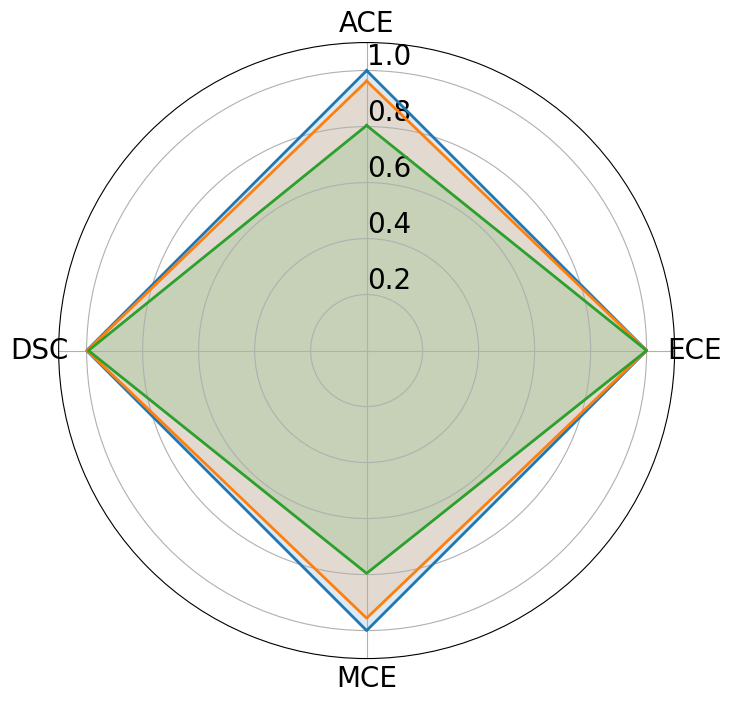

Normalized Spider Plot for ACDC Dataset (MACRO)


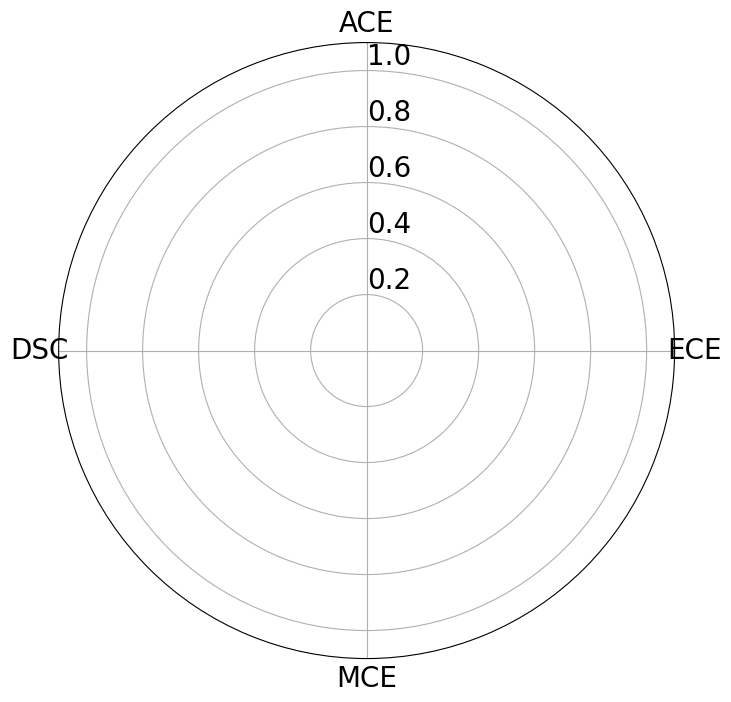

Normalized Spider Plot for KITS Dataset (MACRO)


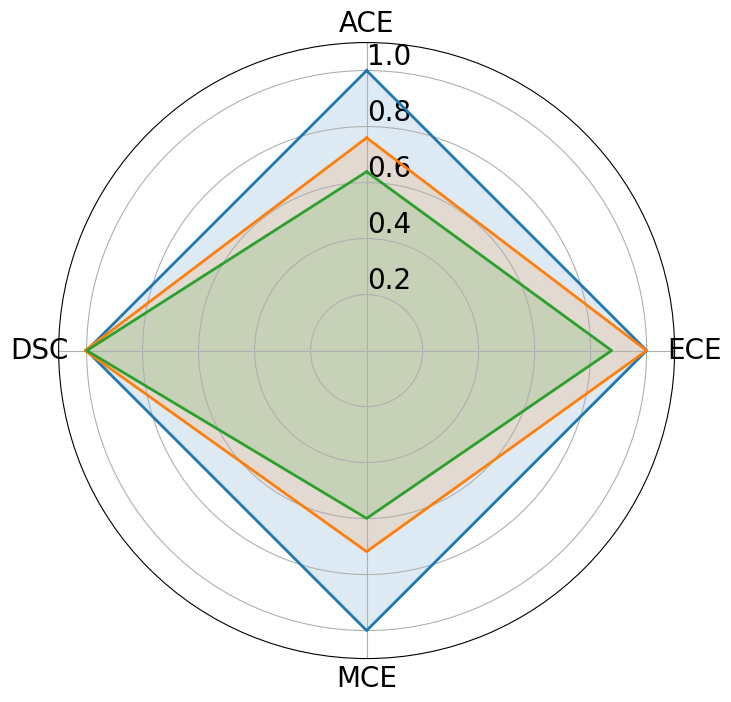

Normalized Spider Plot for BRATS Dataset (MACRO)


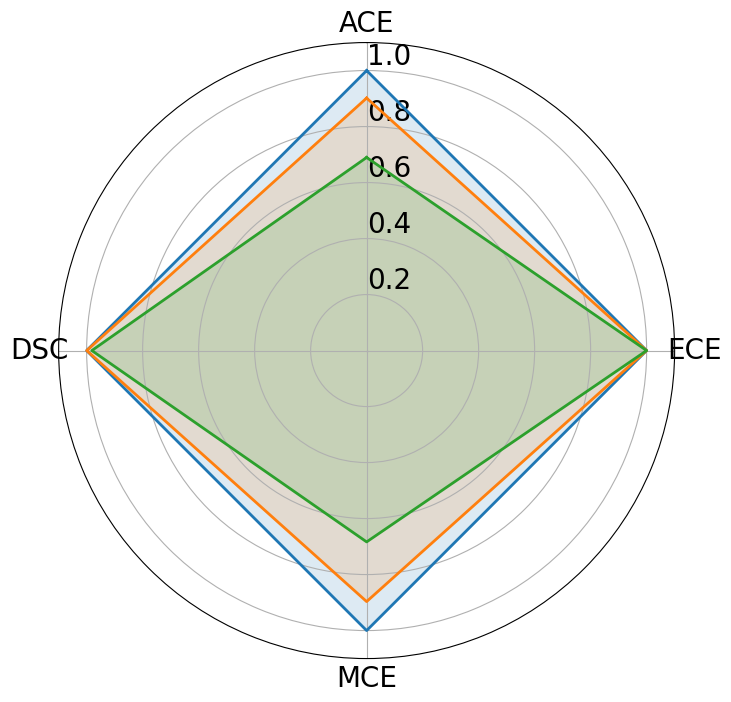

In [55]:
create_spider_plot(results, avg_type="macro", save_fig=True)

In [56]:
create_combined_dsc_ace_table(results, avg_type="micro")


| Loss Function   | ACDC 17 DSC   | ACDC 17 MICRO ACE   | AMOS 22 DSC   | AMOS 22 MICRO ACE   | KiTS 23 DSC   | KiTS 23 MICRO ACE   | BraTS 21 DSC   | BraTS 21 MICRO ACE   |
|:----------------|:--------------|:--------------------|:--------------|:--------------------|:--------------|:--------------------|:---------------|:---------------------|
| Baseline        | N/A           | N/A                 | 0.884 ± 0.042 | 0.060 ± 0.000       | 0.866 ± 0.141 | 0.092 ± 0.000       | 0.911 ± 0.099  | 0.060 ± 0.000        |
| Hard L1-ACE     | N/A           | N/A                 | 0.882 ± 0.044 | 0.053 ± 0.000       | 0.871 ± 0.126 | 0.054 ± 0.000       | 0.911 ± 0.105  | 0.050 ± 0.000        |
| Soft L1-ACE     | N/A           | N/A                 | 0.878 ± 0.041 | 0.029 ± 0.000       | 0.866 ± 0.130 | 0.043 ± 0.000       | 0.895 ± 0.120  | 0.025 ± 0.000        |


Normalized Spider Plot for AMOS Dataset (MICRO)


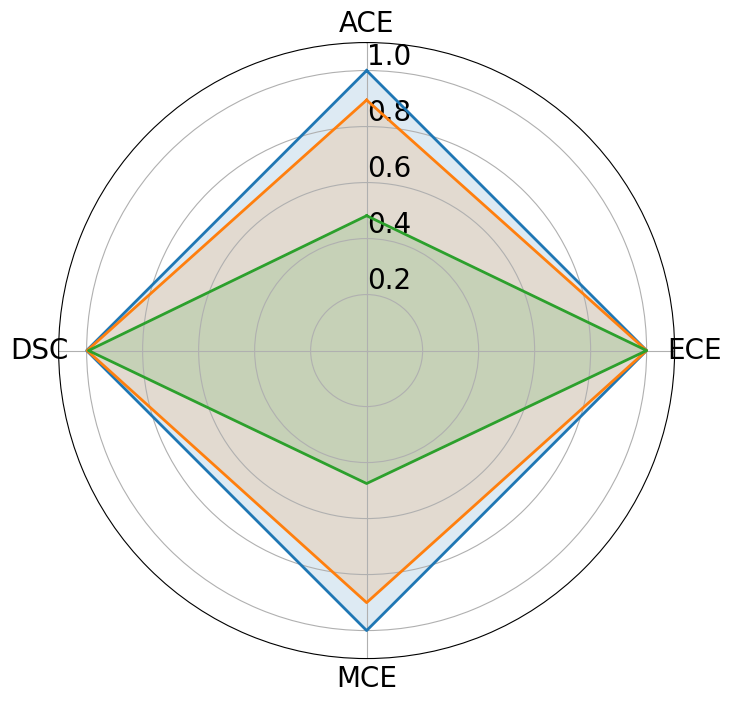

Normalized Spider Plot for ACDC Dataset (MICRO)


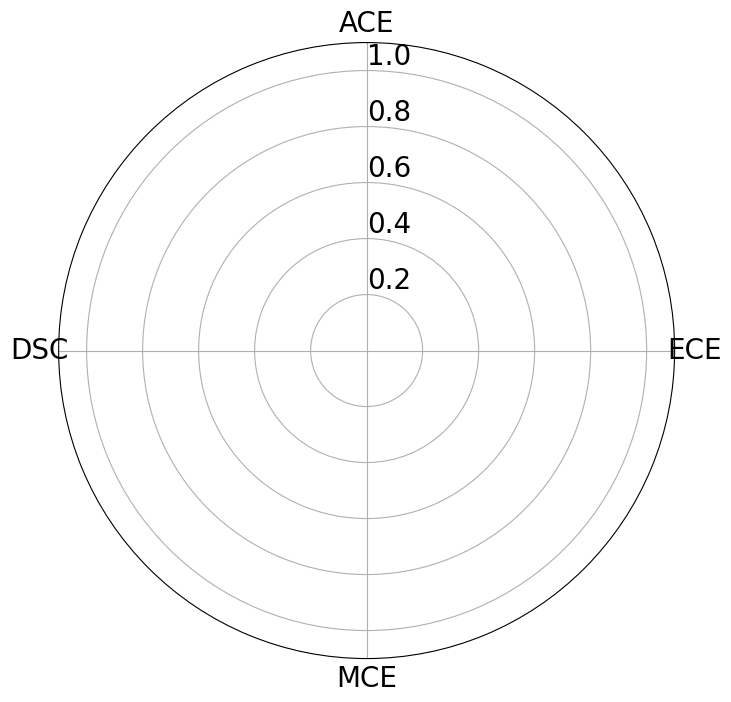

Normalized Spider Plot for KITS Dataset (MICRO)


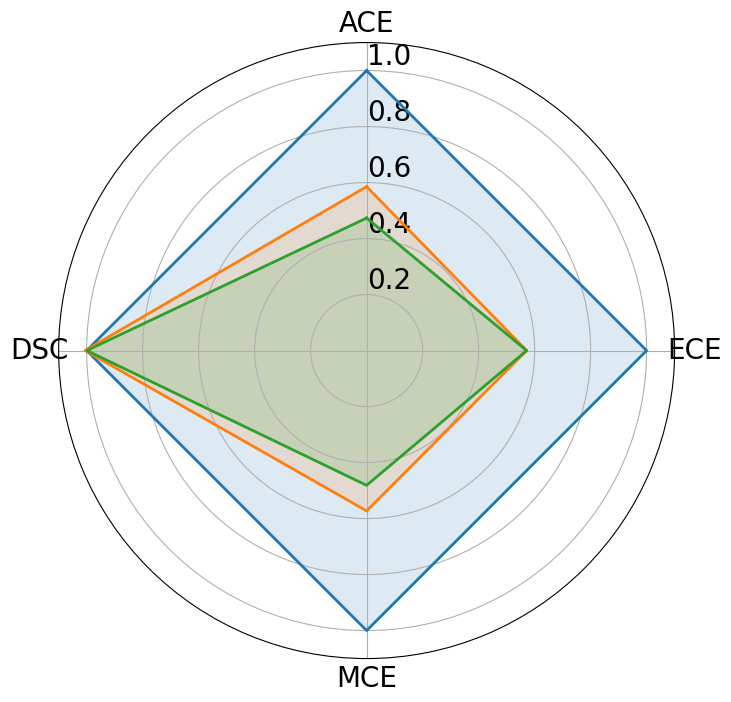

Normalized Spider Plot for BRATS Dataset (MICRO)


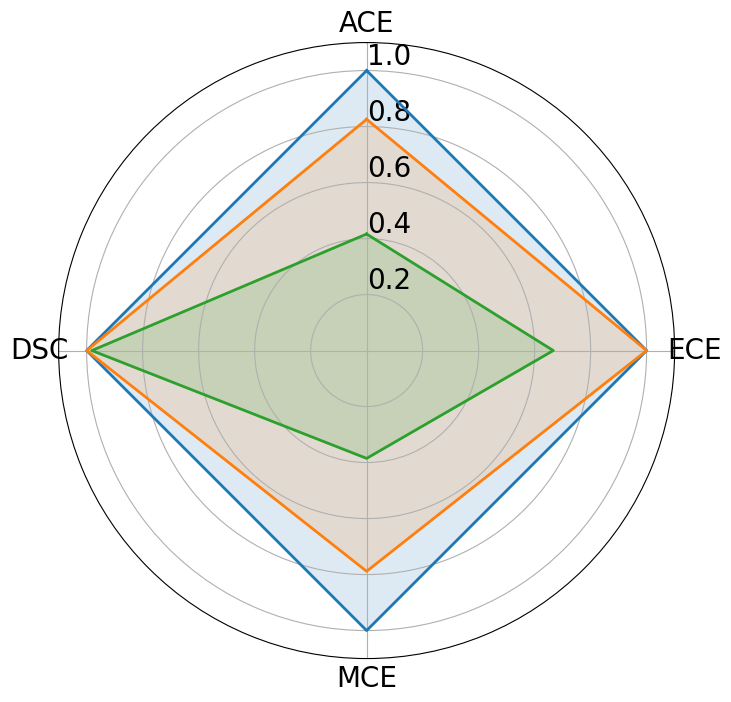

In [57]:
create_spider_plot(results, avg_type="micro", save_fig=True)

## 2. Table and Radar Plot showing model from best validation epoch evaluated on non HEC classes (brats and kits)

In [58]:
RUNS_no_HEC = {
    "kits": {
        "baseline": "bundles/kits23_baseline_dice_ce_nl",
        "hardl1ace": "bundles/kits23_hardl1ace_dice_ce_nl",
        "softl1ace": "bundles/kits23_softl1ace_dice_ce_nl",
    },
    "brats": {
        "baseline": "bundles/brats21_baseline_dice_ce_nl",
        "hardl1ace": "bundles/brats21_hardl1ace_dice_ce_nl",
        "softl1ace": "bundles/brats21_softl1ace_dice_ce_nl",
    },
}

results_no_HEC = load_results(RUNS_no_HEC, no_HEC=True)
create_combined_dsc_ace_table(results_no_HEC, avg_type="macro")

Loaded kits baseline
Loaded kits hardl1ace
Loaded kits softl1ace
Loaded brats baseline
Loaded brats hardl1ace
Loaded brats softl1ace
| Loss Function   | ACDC 17 DSC   | ACDC 17 MACRO ACE   | AMOS 22 DSC   | AMOS 22 MACRO ACE   | KiTS 23 DSC   | KiTS 23 MACRO ACE   | BraTS 21 DSC   | BraTS 21 MACRO ACE   |
|:----------------|:--------------|:--------------------|:--------------|:--------------------|:--------------|:--------------------|:---------------|:---------------------|
| Baseline        | N/A           | N/A                 | N/A           | N/A                 | 0.828 ± 0.128 | 0.161 ± 0.064       | 0.843 ± 0.142  | 0.148 ± 0.068        |
| Hard L1-ACE     | N/A           | N/A                 | N/A           | N/A                 | 0.822 ± 0.124 | 0.134 ± 0.059       | 0.842 ± 0.147  | 0.141 ± 0.067        |
| Soft L1-ACE     | N/A           | N/A                 | N/A           | N/A                 | 0.809 ± 0.131 | 0.115 ± 0.054       | 0.823 ± 0.149  | 0.110 ± 0.062       

Normalized Spider Plot for AMOS Dataset (MACRO)


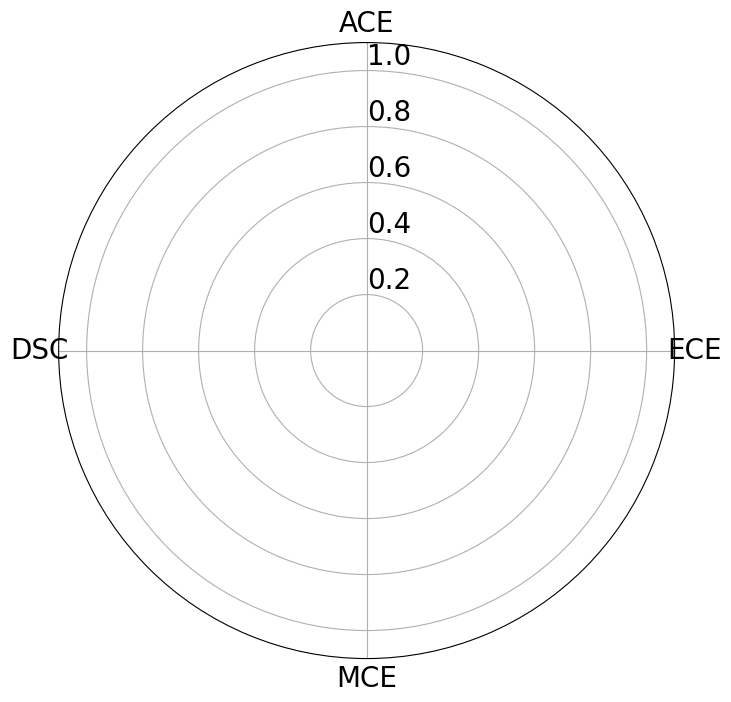

Normalized Spider Plot for ACDC Dataset (MACRO)


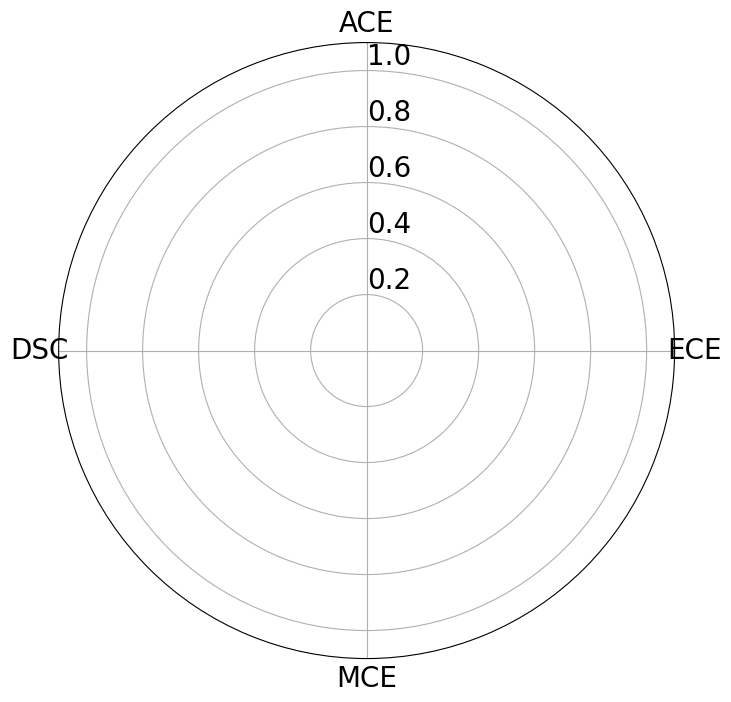

Normalized Spider Plot for KITS Dataset (MACRO)


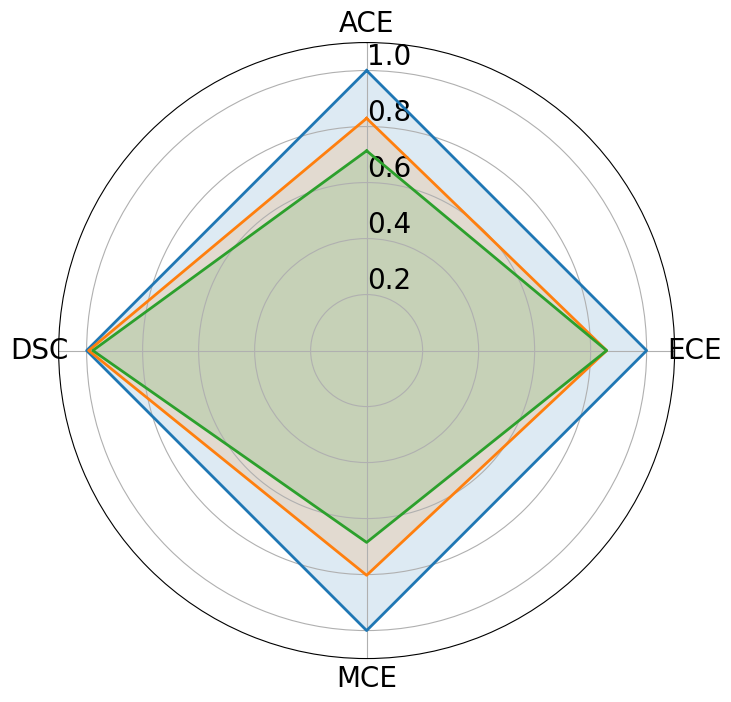

Normalized Spider Plot for BRATS Dataset (MACRO)


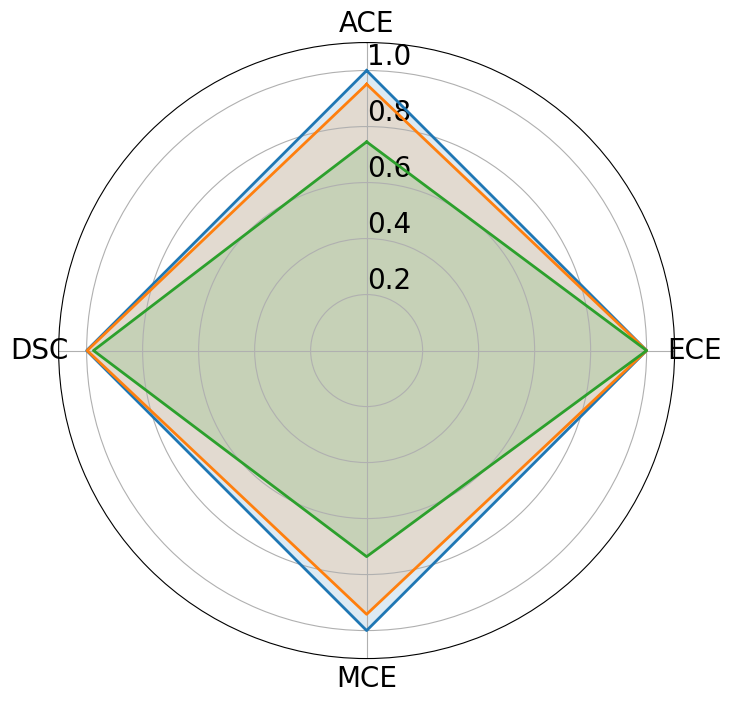

In [59]:
create_spider_plot(results_no_HEC, avg_type="macro")

In [60]:
create_combined_dsc_ace_table(results_no_HEC, avg_type="micro")

| Loss Function   | ACDC 17 DSC   | ACDC 17 MICRO ACE   | AMOS 22 DSC   | AMOS 22 MICRO ACE   | KiTS 23 DSC   | KiTS 23 MICRO ACE   | BraTS 21 DSC   | BraTS 21 MICRO ACE   |
|:----------------|:--------------|:--------------------|:--------------|:--------------------|:--------------|:--------------------|:---------------|:---------------------|
| Baseline        | N/A           | N/A                 | N/A           | N/A                 | 0.828 ± 0.128 | 0.102 ± 0.000       | 0.843 ± 0.142  | 0.062 ± 0.000        |
| Hard L1-ACE     | N/A           | N/A                 | N/A           | N/A                 | 0.822 ± 0.124 | 0.050 ± 0.000       | 0.842 ± 0.147  | 0.056 ± 0.000        |
| Soft L1-ACE     | N/A           | N/A                 | N/A           | N/A                 | 0.809 ± 0.131 | 0.053 ± 0.000       | 0.823 ± 0.149  | 0.029 ± 0.000        |


Normalized Spider Plot for AMOS Dataset (MICRO)


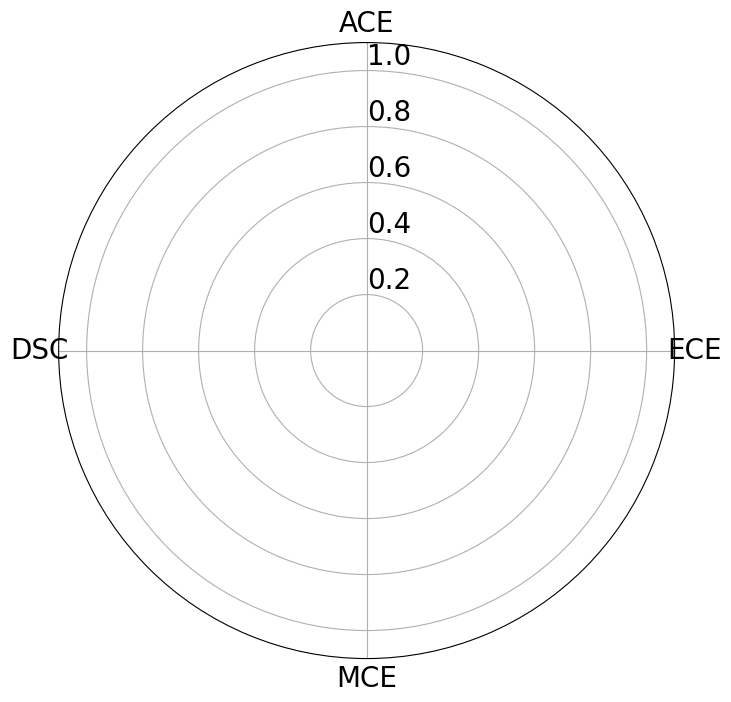

Normalized Spider Plot for ACDC Dataset (MICRO)


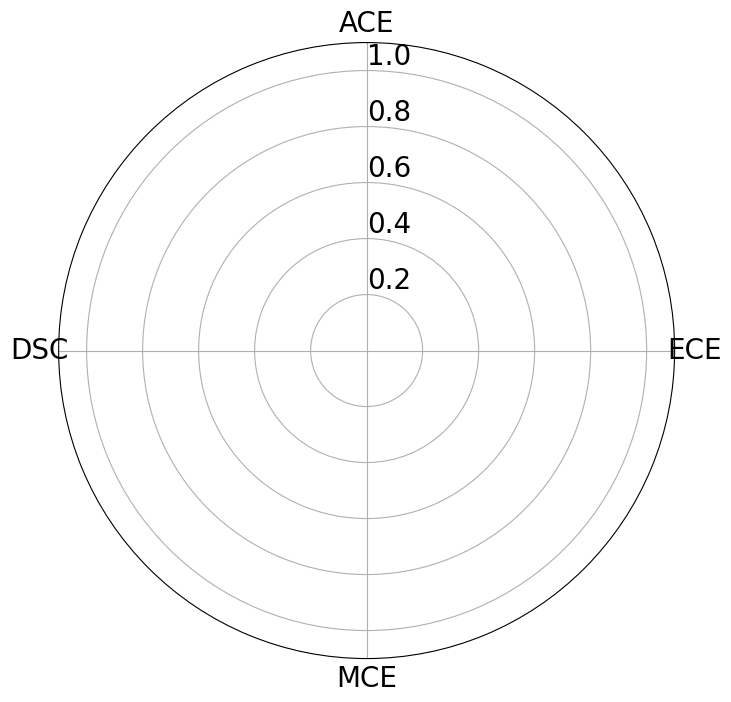

Normalized Spider Plot for KITS Dataset (MICRO)


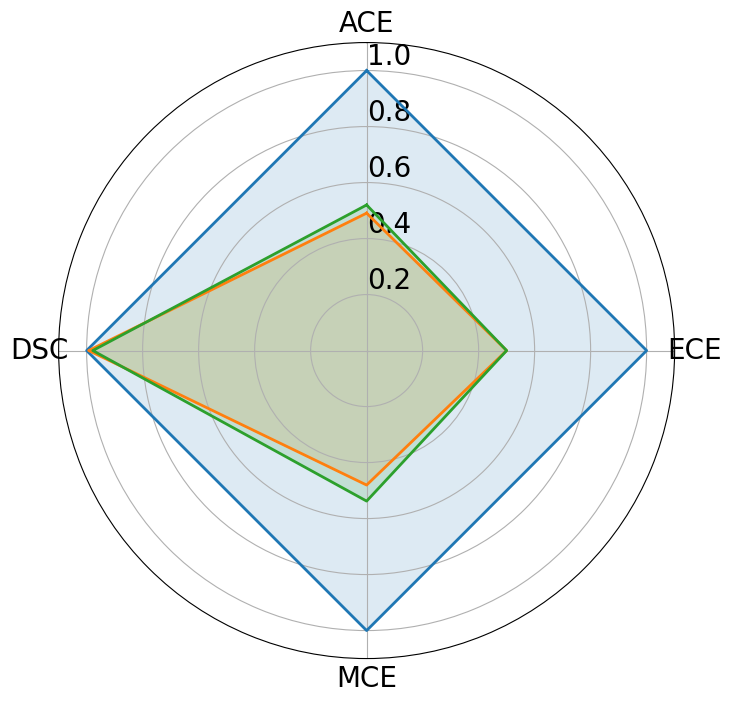

Normalized Spider Plot for BRATS Dataset (MICRO)


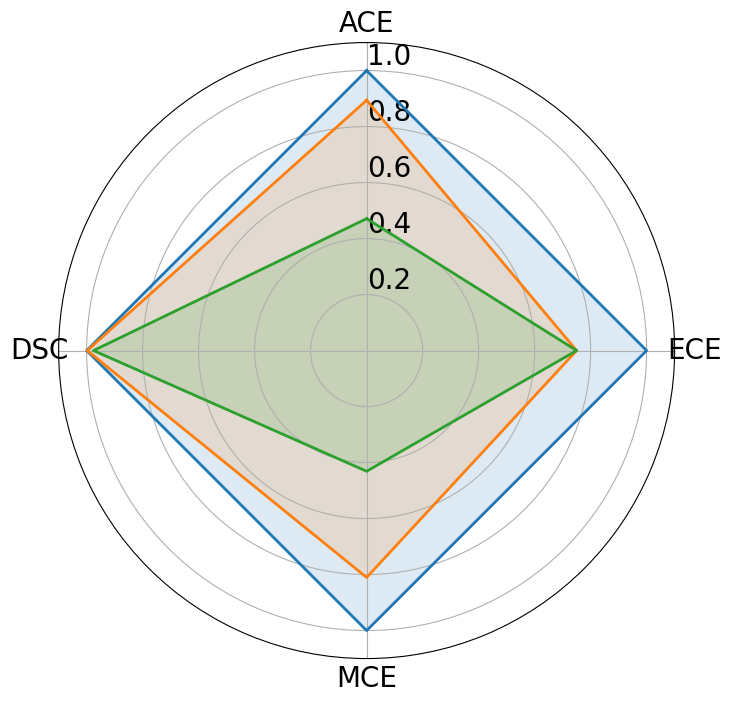

In [61]:
create_spider_plot(results_no_HEC, avg_type="micro")

## 3. Breakdown of KiTS results
- Table of per class metrics

In [62]:
def get_class_metrics(dataframes, dataset_key, run_key, metric, class_index):
    try:
        df = dataframes[dataset_key][run_key][metric]["summary"]
        mean = df["mean"]
        std = df["std"]
        return mean, std
    except KeyError:
        raise KeyError(f"Could not find class {class_index} in {dataset_key} {run_key} {metric}")

def format_value(mean, std):
    if mean < 0.01 or std < 0.01:
        return f"{mean:.1e} ± {std:.1e}"
    else:
        return f"{mean:.3f} ± {std:.3f}"

def create_loss_function_tables(results, class_names, dataset_key):
    metrics = ["DSC", "micro_ACE", "macro_ACE", "micro_ECE", "macro_ECE", "micro_MCE", "macro_MCE"]
    loss_functions = ["baseline", "hardl1ace", "softl1ace"]
    
    for loss_function in loss_functions:
        table_data = []
        for class_index, class_name in enumerate(class_names):
            row = [class_name]
            for metric in metrics:
                mean_series, std_series = get_class_metrics(results, dataset_key, loss_function, metric, class_index)
                if mean_series is not None and std_series is not None:
                    mean = mean_series.iloc[class_index]
                    std = std_series.iloc[class_index]
                    row.append(format_value(mean, std))
                else:
                    row.append("N/A")
            table_data.append(row)
        
        headers = ["Class"] + metrics
        print(f"Results for loss function: {loss_function}")
        print(tabulate(table_data, headers=headers, tablefmt="pipe"))
        print("\n")
        
def create_class_spider_plot(results, class_names, dataset_key, avg_type="micro"):
    metrics = ["ACE", "ECE", "MCE", "DSC"]
    loss_functions = ["baseline", "hardl1ace", "softl1ace"]
    output_dir = f"radar_plots_complete_classes/{dataset_key}breakdown"
    os.makedirs(output_dir, exist_ok=True)
    
    for class_index, class_name in enumerate(class_names):
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]
        
        baseline_values = []
        for metric in metrics:
            metric_key = f"{avg_type}_{metric}" if metric != "DSC" else metric
            try:
                df = results[dataset_key]["baseline"][metric_key]["summary"]
                mean = df["mean"].iloc[class_index]
                baseline_values.append(mean)
            except KeyError:
                baseline_values.append(1)
        
        for loss_function in loss_functions:
            values = []
            for metric, baseline in zip(metrics, baseline_values):
                metric_key = f"{avg_type}_{metric}" if metric != "DSC" else metric
                try:
                    df = results[dataset_key][loss_function][metric_key]["summary"]
                    mean = df["mean"].iloc[class_index]
                    normalized_value = mean / baseline if baseline != 0 else 0
                    values.append(normalized_value)
                except KeyError:
                    values.append(0)
            values += values[:1]
            ax.plot(angles, values, linewidth=2, linestyle="solid", label=loss_function)
            ax.fill(angles, values, alpha=0.15)
        
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        plt.xticks(angles[:-1], metrics, fontsize=20)  # Set axis labels to DSC, ACE, ECE, MCE
        ax.set_rlabel_position(0)
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color="black", size=20)
        plt.ylim(0, 1.1)
        
        # plt.title(f"Normalized Spider Plot for {class_name} ({avg_type.upper()})", size=20, color="black", y=1.1)
        # plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
        
        print(f"Normalized Spider Plot for {class_name} ({avg_type.upper()})")
        
        pdf_filename = os.path.join(output_dir, f"normalized_spider_plot_{class_name}_{avg_type}.pdf")
        plt.savefig(pdf_filename, format="pdf")
        plt.show()

In [63]:
kits_class_names_hec = ['tumour', 'kidney_mass', 'kindey_and_masses']
create_loss_function_tables(results, kits_class_names_hec, "kits")

Results for loss function: baseline
| Class             | DSC           | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|:------------------|:--------------|:------------------|:--------------|:------------------|:------------------|:------------------|:--------------|
| tumour            | 0.799 ± 0.240 | 1.2e-01 ± 0.0e+00 | 0.208 ± 0.118 | 7.0e-04 ± 0.0e+00 | 8.0e-04 ± 1.2e-03 | 2.5e-01 ± 0.0e+00 | 0.400 ± 0.197 |
| kidney_mass       | 0.826 ± 0.189 | 1.1e-01 ± 0.0e+00 | 0.196 ± 0.095 | 8.0e-04 ± 0.0e+00 | 1.0e-03 ± 1.2e-03 | 2.1e-01 ± 0.0e+00 | 0.391 ± 0.176 |
| kindey_and_masses | 0.974 ± 0.018 | 4.8e-02 ± 0.0e+00 | 0.083 ± 0.047 | 5.0e-04 ± 0.0e+00 | 7.0e-04 ± 9.0e-04 | 9.0e-02 ± 0.0e+00 | 0.159 ± 0.083 |


Results for loss function: hardl1ace
| Class             | DSC               | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|:------------------|

Normalized Spider Plot for tumour (MACRO)


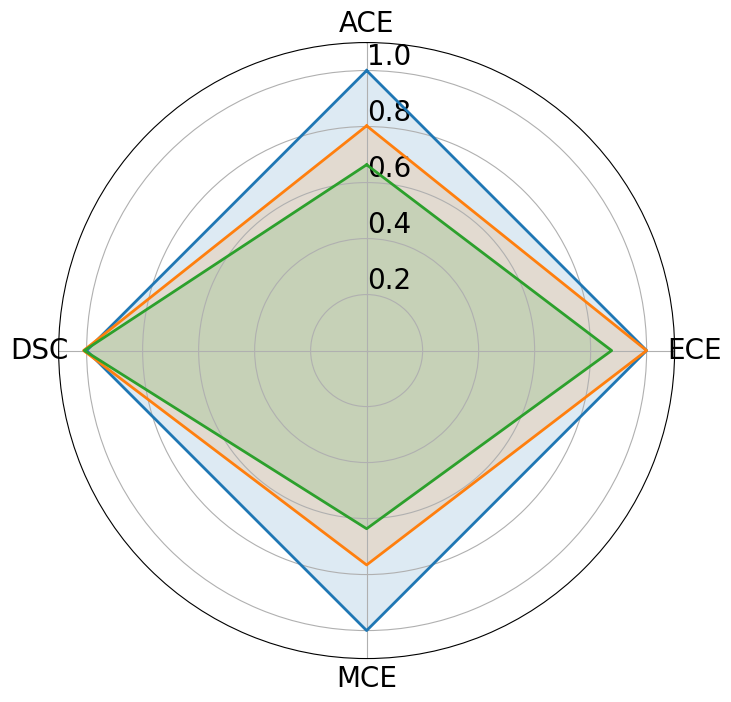

Normalized Spider Plot for kidney_mass (MACRO)


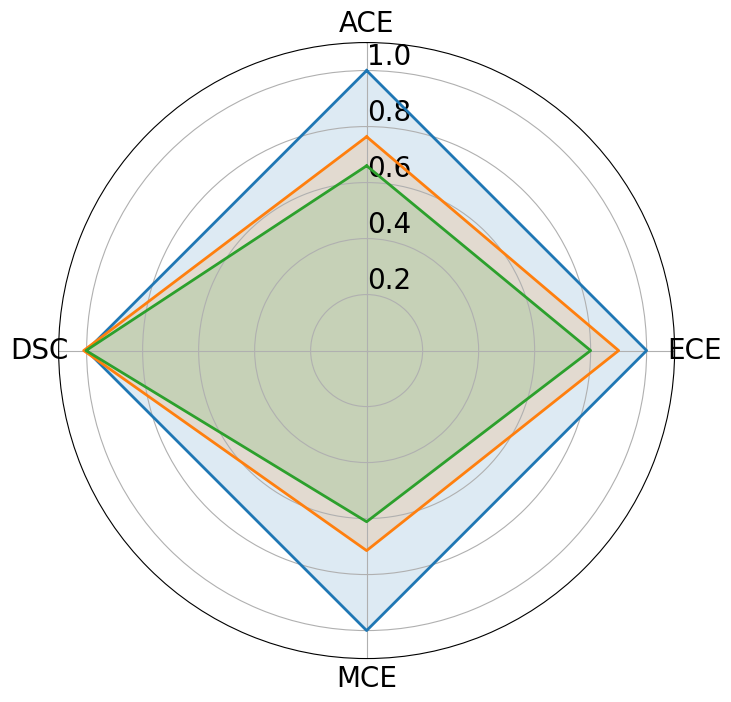

Normalized Spider Plot for kindey_and_masses (MACRO)


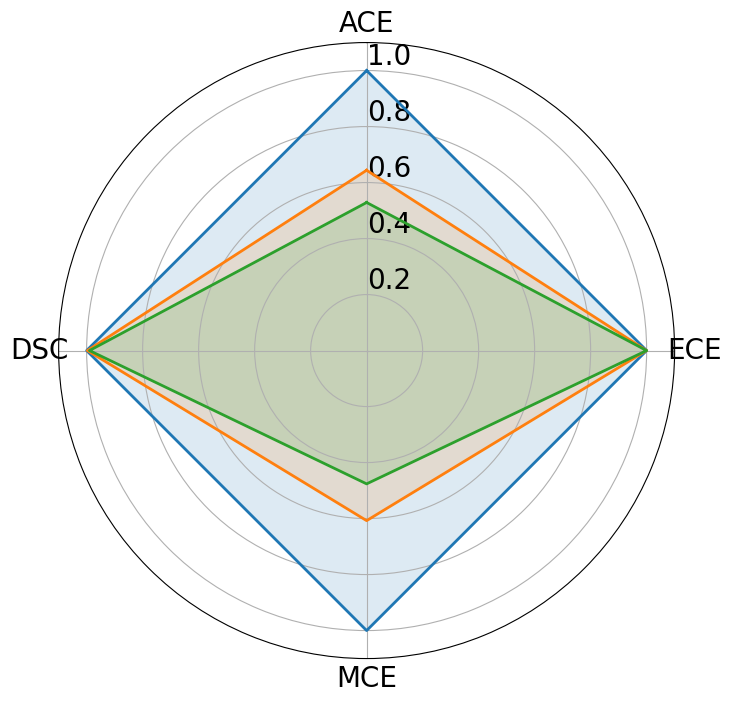

Normalized Spider Plot for tumour (MICRO)


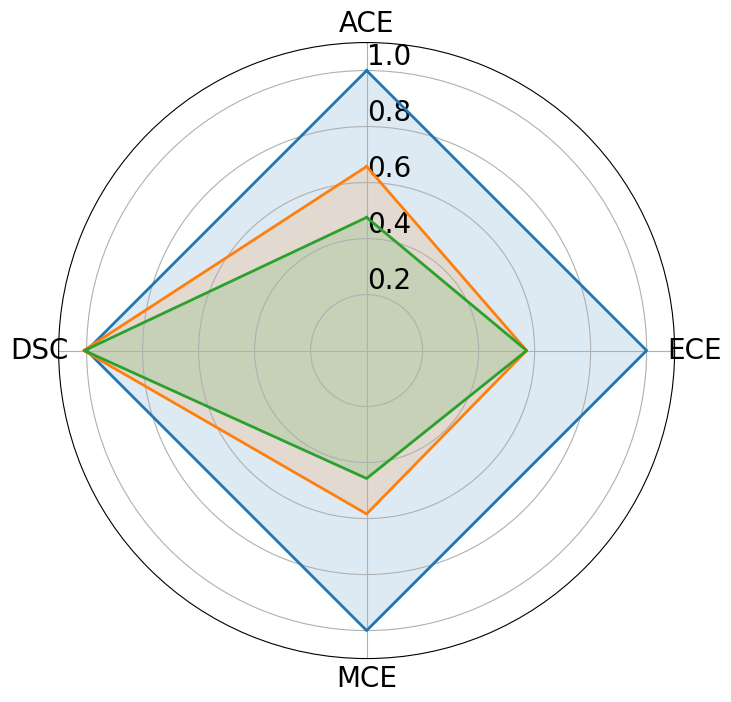

Normalized Spider Plot for kidney_mass (MICRO)


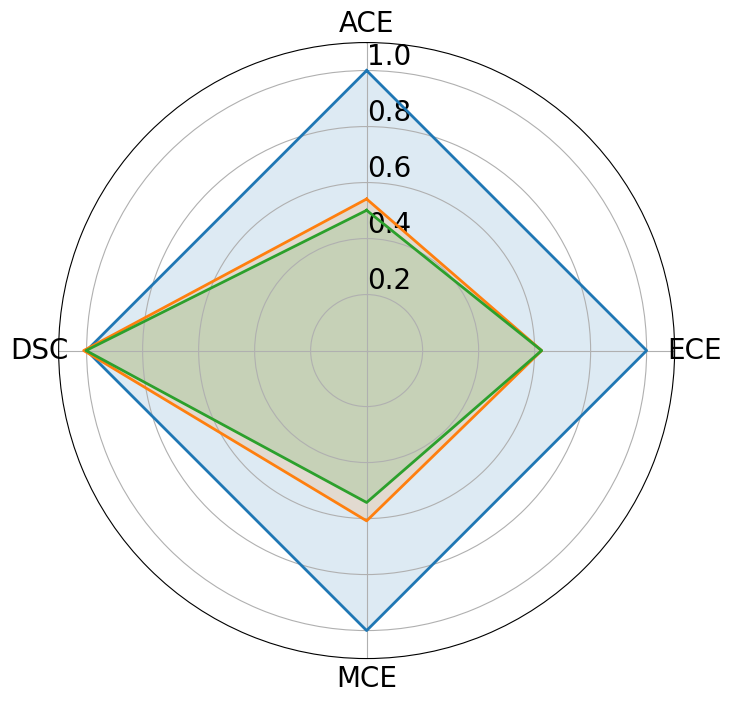

Normalized Spider Plot for kindey_and_masses (MICRO)


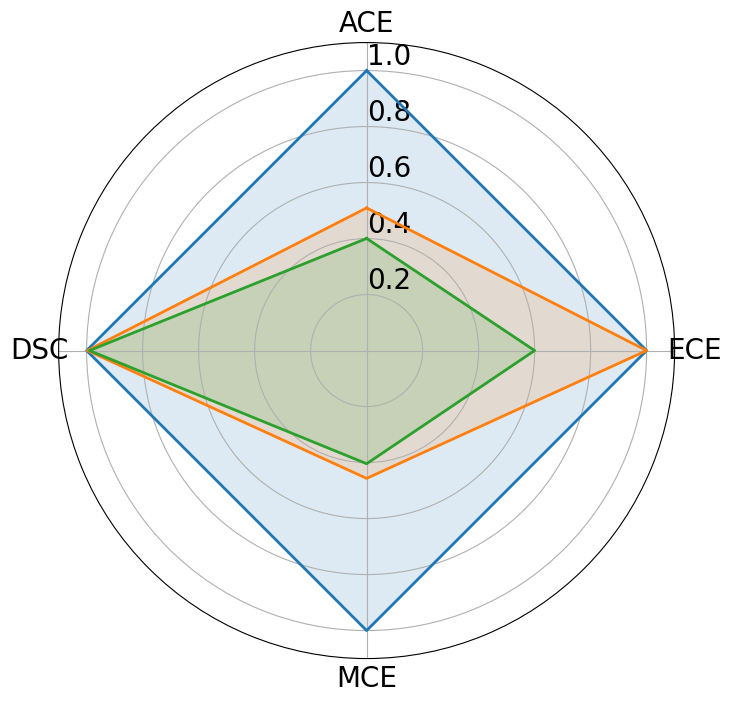

In [64]:
create_class_spider_plot(results, kits_class_names_hec, "kits", avg_type="macro")
create_class_spider_plot(results, kits_class_names_hec, "kits", avg_type="micro")

In [65]:
kits_class_names_no_hec = ['kidney', 'tumour', 'cyst']
create_loss_function_tables(results_no_HEC, kits_class_names_no_hec, "kits")

Results for loss function: baseline
| Class   | DSC           | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|:--------|:--------------|:------------------|:--------------|:------------------|:------------------|:------------------|:--------------|
| kidney  | 0.959 ± 0.023 | 4.9e-02 ± 0.0e+00 | 0.080 ± 0.040 | 8.0e-04 ± 0.0e+00 | 9.0e-04 ± 8.0e-04 | 8.1e-02 ± 0.0e+00 | 0.159 ± 0.076 |
| tumour  | 0.799 ± 0.240 | 1.2e-01 ± 0.0e+00 | 0.208 ± 0.118 | 7.0e-04 ± 0.0e+00 | 8.0e-04 ± 1.2e-03 | 2.5e-01 ± 0.0e+00 | 0.400 ± 0.197 |
| cyst    | 0.725 ± 0.254 | 1.4e-01 ± 0.0e+00 | 0.196 ± 0.114 | 2.0e-04 ± 0.0e+00 | 2.0e-04 ± 4.0e-04 | 2.9e-01 ± 0.0e+00 | 0.404 ± 0.219 |


Results for loss function: hardl1ace
| Class   | DSC           | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|:--------|:--------------|:------------------|:--------------|:------------------|:-

Normalized Spider Plot for kidney (MACRO)


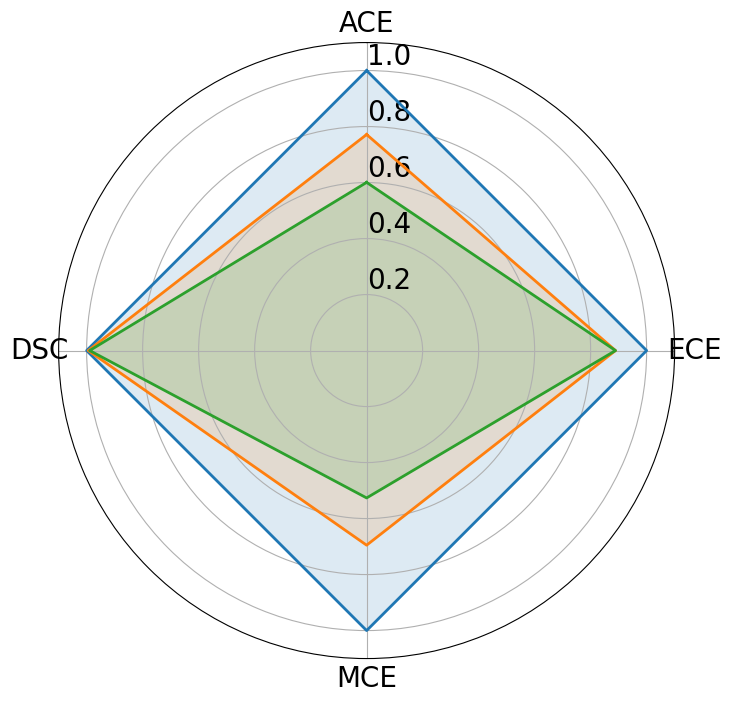

Normalized Spider Plot for tumour (MACRO)


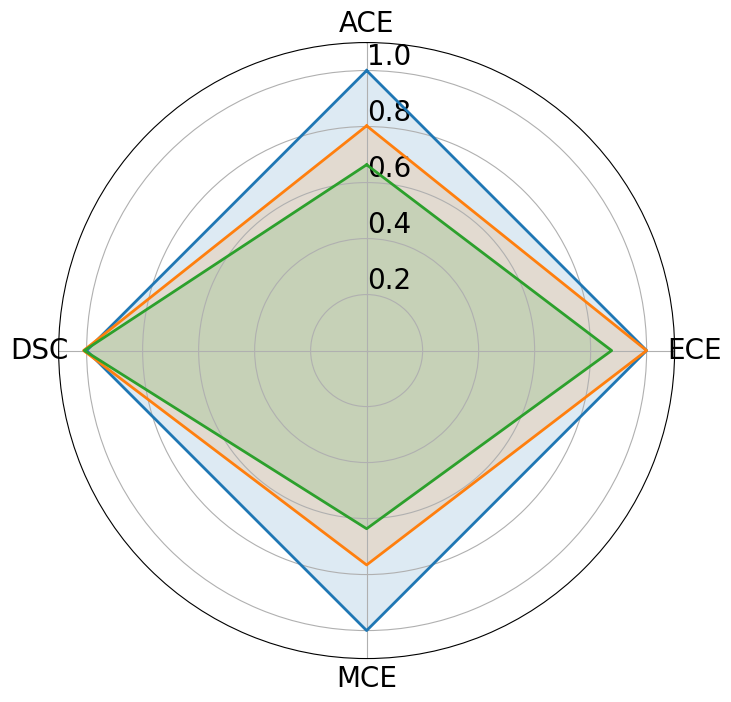

Normalized Spider Plot for cyst (MACRO)


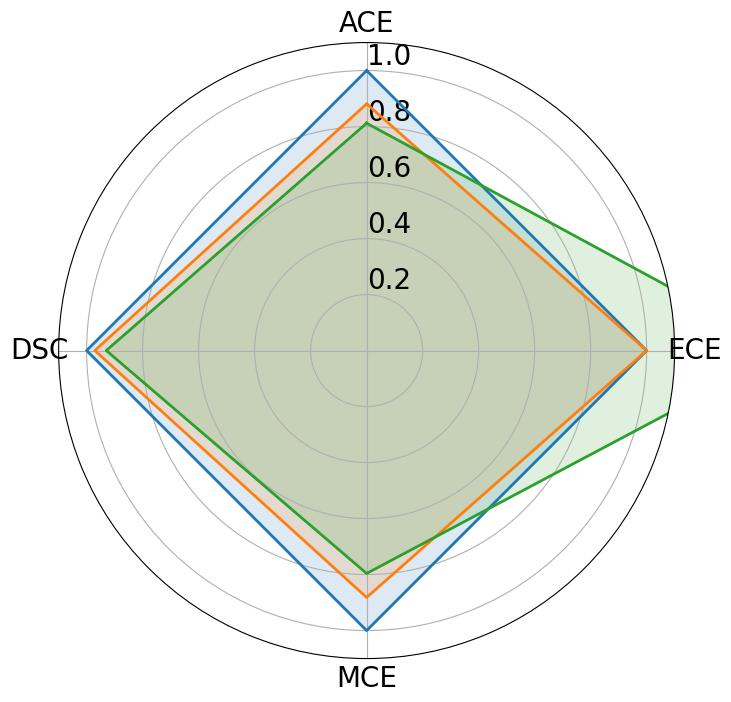

Normalized Spider Plot for kidney (MICRO)


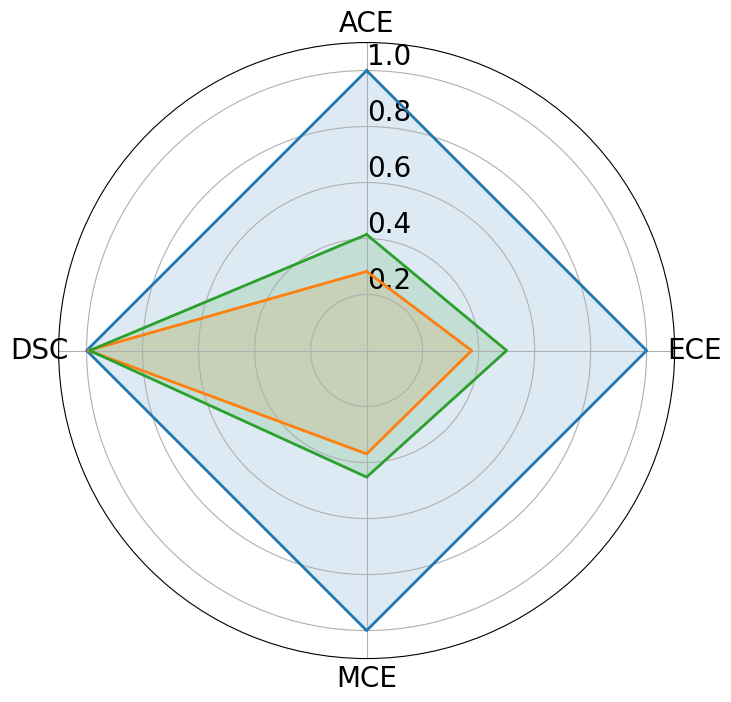

Normalized Spider Plot for tumour (MICRO)


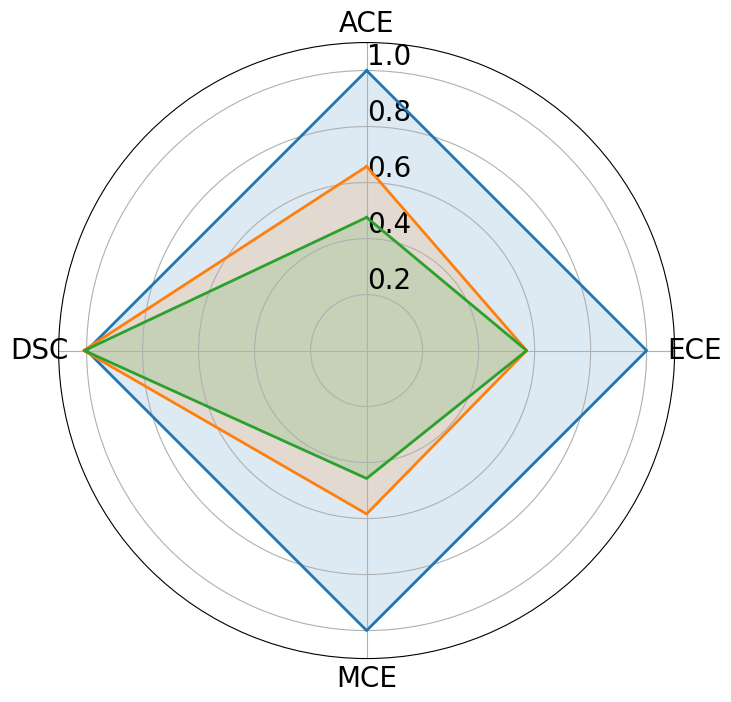

Normalized Spider Plot for cyst (MICRO)


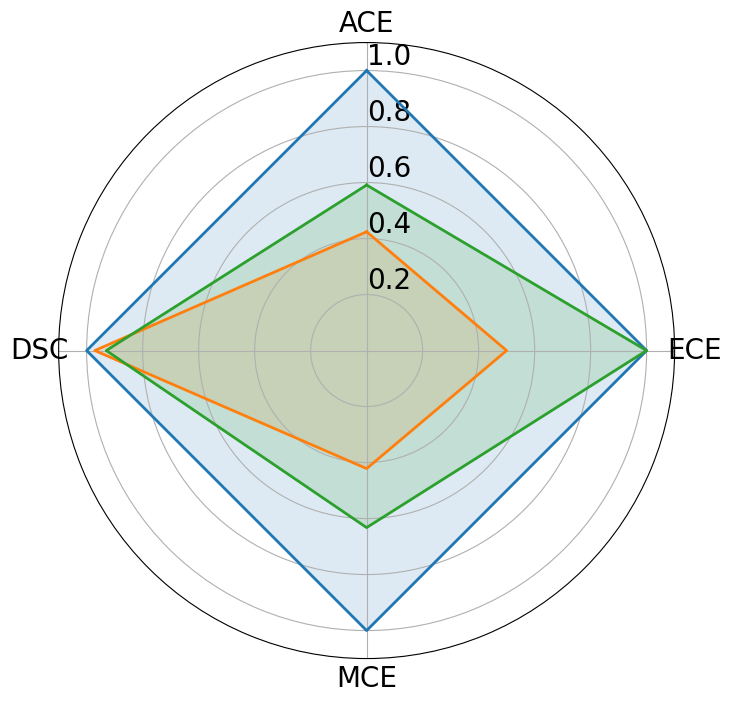

In [66]:
create_class_spider_plot(results_no_HEC, kits_class_names_no_hec, "kits", avg_type="macro")
create_class_spider_plot(results_no_HEC, kits_class_names_no_hec, "kits", avg_type="micro")

## 4. Breakdown of BraTS results

- Table of per class metrics

In [67]:
brats_class_names_hec = ['Enhancing Tumour (ET)', 'Tumour Core (TC)', 'Whole Tumour (WT)']  # HEC classes
create_loss_function_tables(results, brats_class_names_hec, "brats")

Results for loss function: baseline
| Class                 | DSC           | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|:----------------------|:--------------|:------------------|:--------------|:------------------|:------------------|:------------------|:--------------|
| Enhancing Tumour (ET) | 0.883 ± 0.149 | 4.0e-02 ± 0.0e+00 | 0.127 ± 0.081 | 2.0e-04 ± 0.0e+00 | 3.0e-04 ± 7.0e-04 | 8.1e-02 ± 0.0e+00 | 0.259 ± 0.151 |
| Tumour Core (TC)      | 0.925 ± 0.126 | 7.6e-02 ± 0.0e+00 | 0.143 ± 0.089 | 3.0e-04 ± 0.0e+00 | 3.0e-04 ± 8.0e-04 | 1.5e-01 ± 0.0e+00 | 0.292 ± 0.160 |
| Whole Tumour (WT)     | 0.926 ± 0.098 | 6.5e-02 ± 0.0e+00 | 0.157 ± 0.097 | 6.0e-04 ± 0.0e+00 | 8.0e-04 ± 1.1e-03 | 1.3e-01 ± 0.0e+00 | 0.291 ± 0.168 |


Results for loss function: hardl1ace
| Class                 | DSC           | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|

Normalized Spider Plot for Enhancing Tumour (ET) (MACRO)


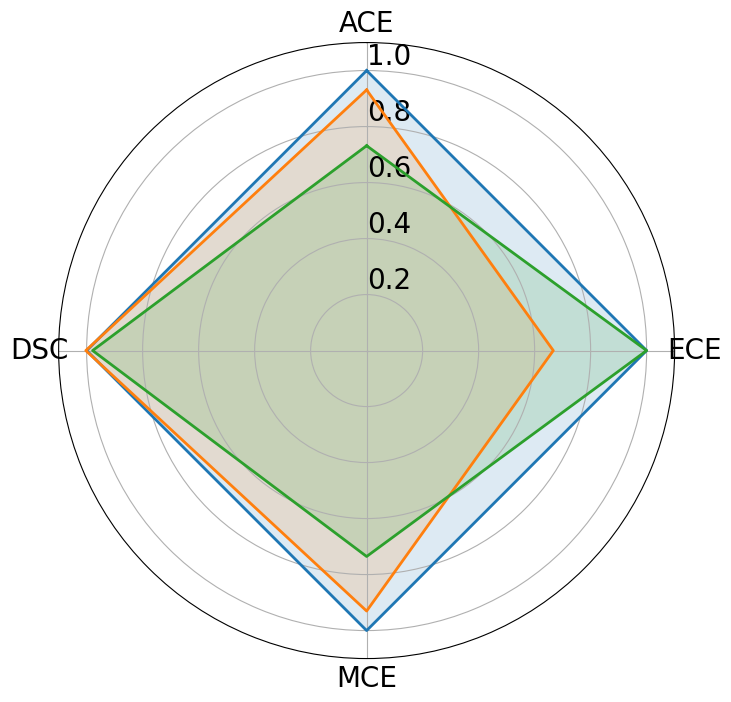

Normalized Spider Plot for Tumour Core (TC) (MACRO)


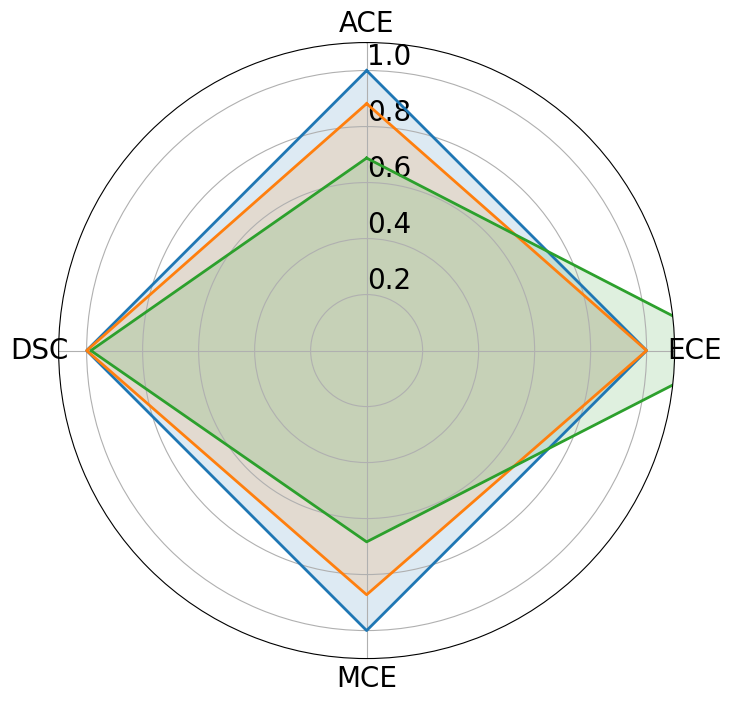

Normalized Spider Plot for Whole Tumour (WT) (MACRO)


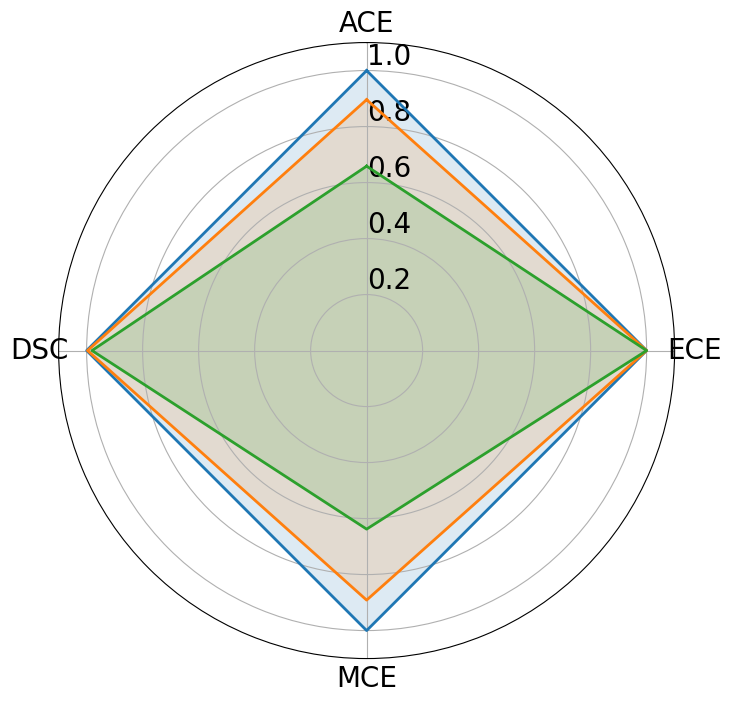

Normalized Spider Plot for Enhancing Tumour (ET) (MICRO)


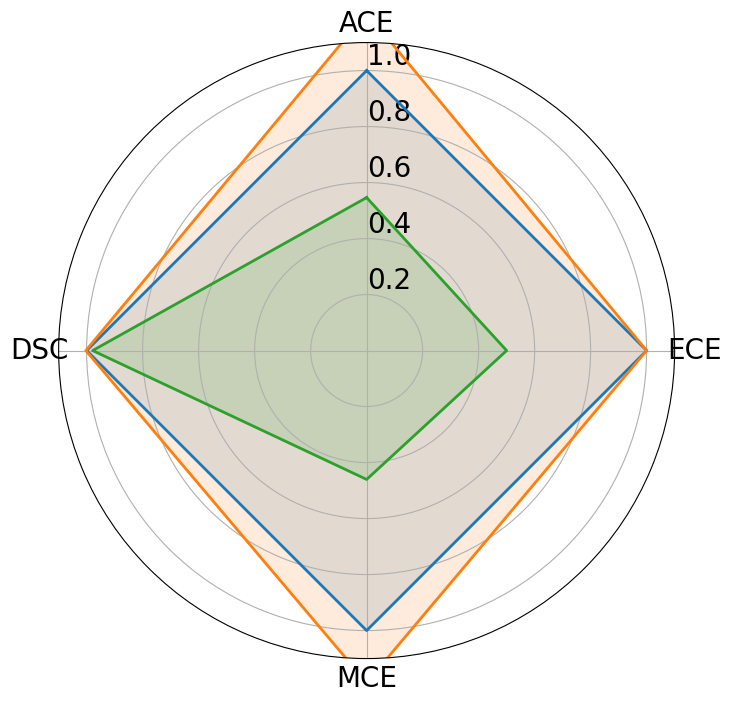

Normalized Spider Plot for Tumour Core (TC) (MICRO)


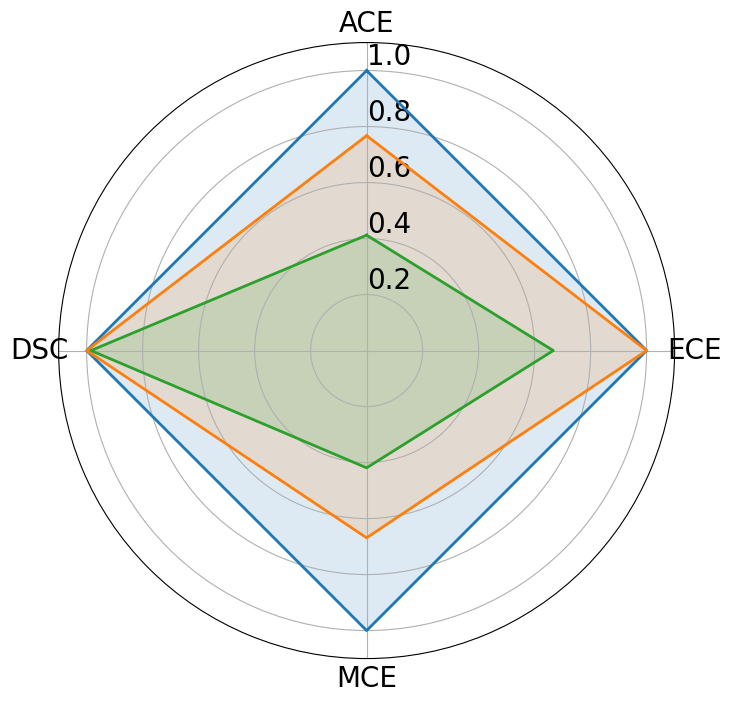

Normalized Spider Plot for Whole Tumour (WT) (MICRO)


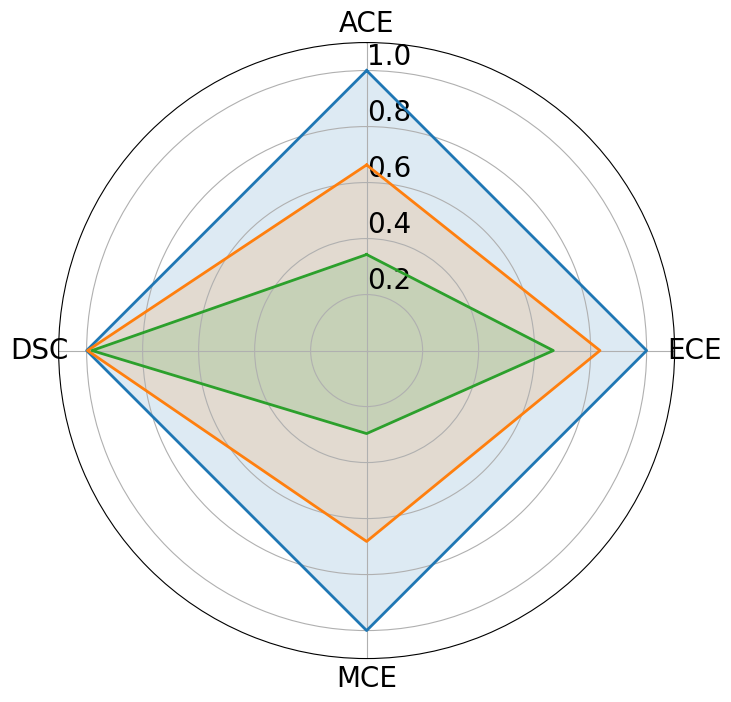

In [68]:
create_class_spider_plot(results, brats_class_names_hec, "brats", avg_type="macro")
create_class_spider_plot(results, brats_class_names_hec, "brats", avg_type="micro")

In [69]:
# brats_class_names_no_hec = ['Necrotic Tumour Core (NCR)', 'Peritumoral Edema (ED)', 'Enhancing Tumour (ET)']  # original classes
# create_loss_function_tables(results, brats_class_names_no_hec, "brats")

In [70]:
# create_class_spider_plot(results, brats_class_names_no_hec, "brats", avg_type="macro")
# create_class_spider_plot(results, brats_class_names_no_hec, "brats", avg_type="micro")

## 5. Breakdown of AMOS results

- Table of per class metrics

In [71]:
amos_class_names = ['spleen', 'right_kidney', 'left_kidney', 'gallbladder', 'esophagus', 'liver', 'stomach', 'aorta', 'inferior_vena_cava', 'pancreas', 'right_adrenal_gland', 'left_adrenal_gland', 'duodenum', 'bladder', 'prostate or uterus']
create_loss_function_tables(results, amos_class_names, "amos")

Results for loss function: baseline
| Class               | DSC           | micro_ACE         | macro_ACE     | micro_ECE         | macro_ECE         | micro_MCE         | macro_MCE     |
|:--------------------|:--------------|:------------------|:--------------|:------------------|:------------------|:------------------|:--------------|
| spleen              | 0.967 ± 0.021 | 3.2e-02 ± 0.0e+00 | 0.082 ± 0.052 | 1.0e-04 ± 0.0e+00 | 1.0e-04 ± 2.0e-04 | 6.2e-02 ± 0.0e+00 | 0.179 ± 0.095 |
| right_kidney        | 0.961 ± 0.029 | 2.3e-02 ± 0.0e+00 | 0.075 ± 0.044 | 0.0e+00 ± 0.0e+00 | 1.0e-04 ± 2.0e-04 | 6.5e-02 ± 0.0e+00 | 0.164 ± 0.084 |
| left_kidney         | 0.965 ± 0.013 | 1.6e-02 ± 0.0e+00 | 0.069 ± 0.030 | 0.0e+00 ± 0.0e+00 | 1.0e-04 ± 1.0e-04 | 3.1e-02 ± 0.0e+00 | 0.152 ± 0.057 |
| gallbladder         | 0.835 ± 0.215 | 7.8e-02 ± 0.0e+00 | 0.130 ± 0.085 | 1.0e-04 ± 0.0e+00 | 1.0e-04 ± 5.0e-04 | 1.7e-01 ± 0.0e+00 | 0.291 ± 0.157 |
| esophagus           | 0.841 ± 0.102 | 7.9e-02 ± 0.

Normalized Spider Plot for spleen (MACRO)


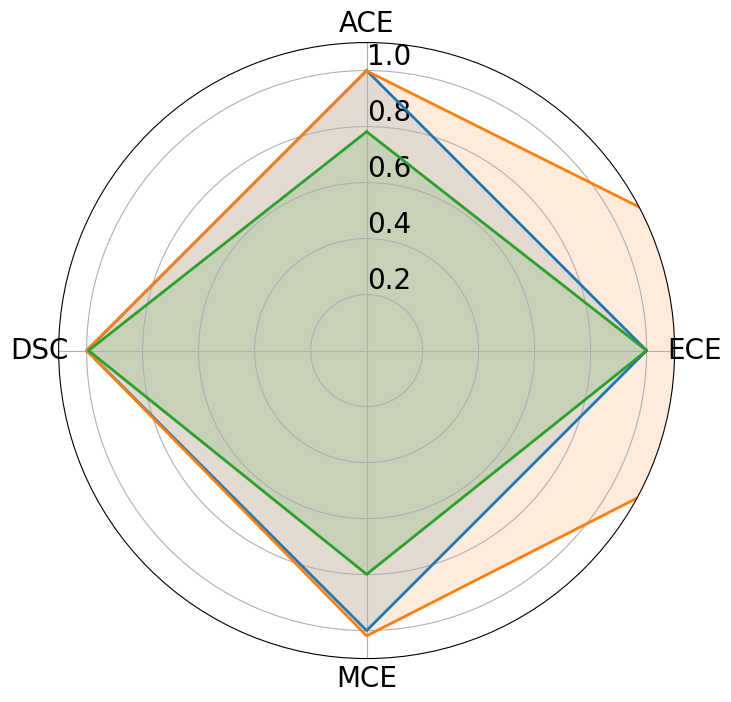

Normalized Spider Plot for right_kidney (MACRO)


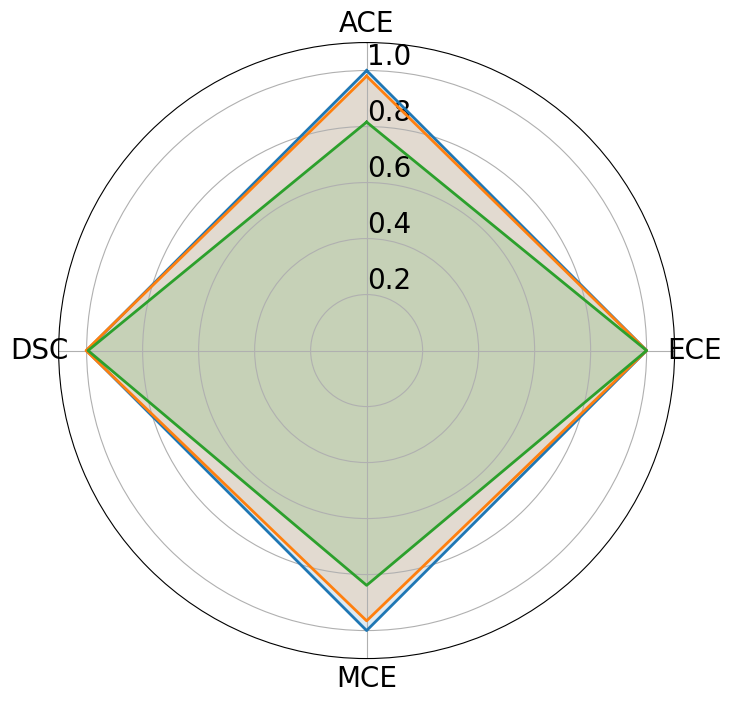

Normalized Spider Plot for left_kidney (MACRO)


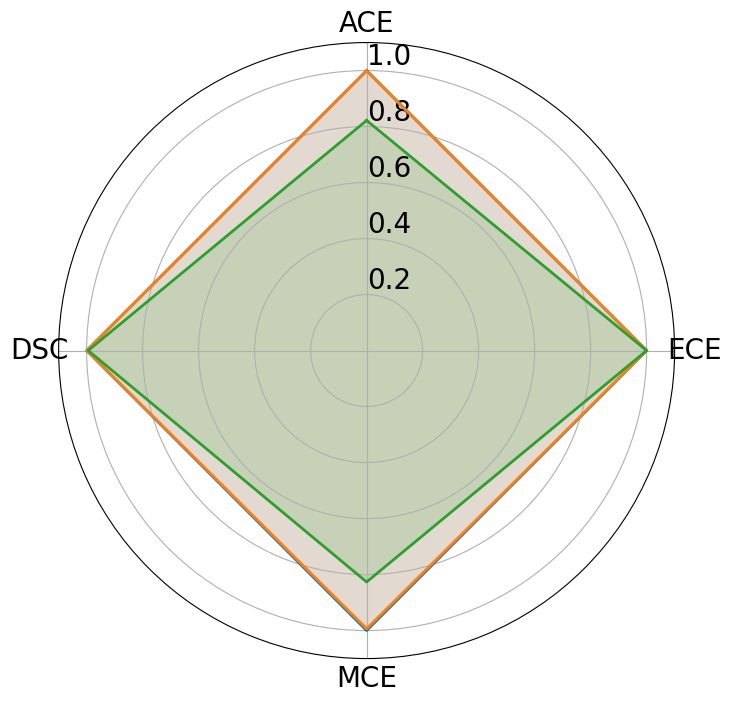

Normalized Spider Plot for gallbladder (MACRO)


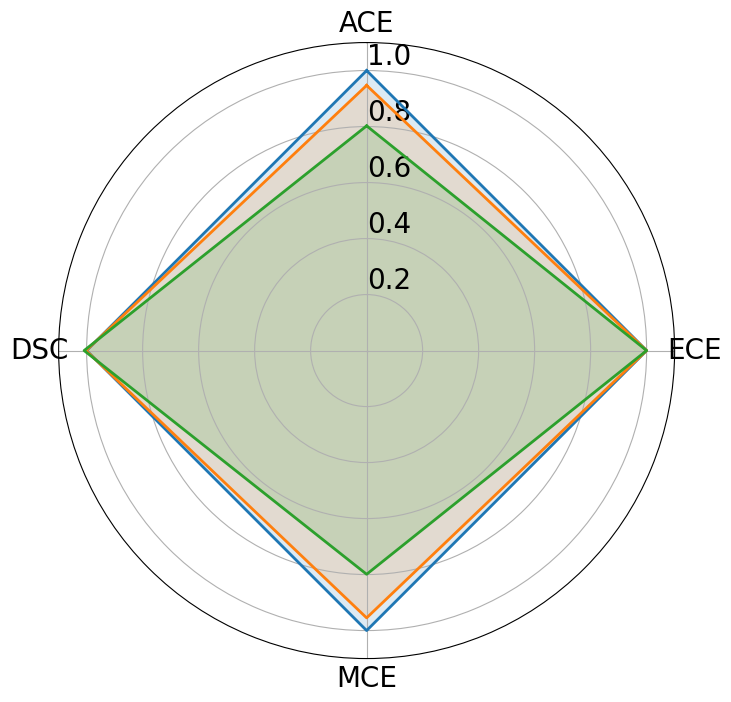

Normalized Spider Plot for esophagus (MACRO)


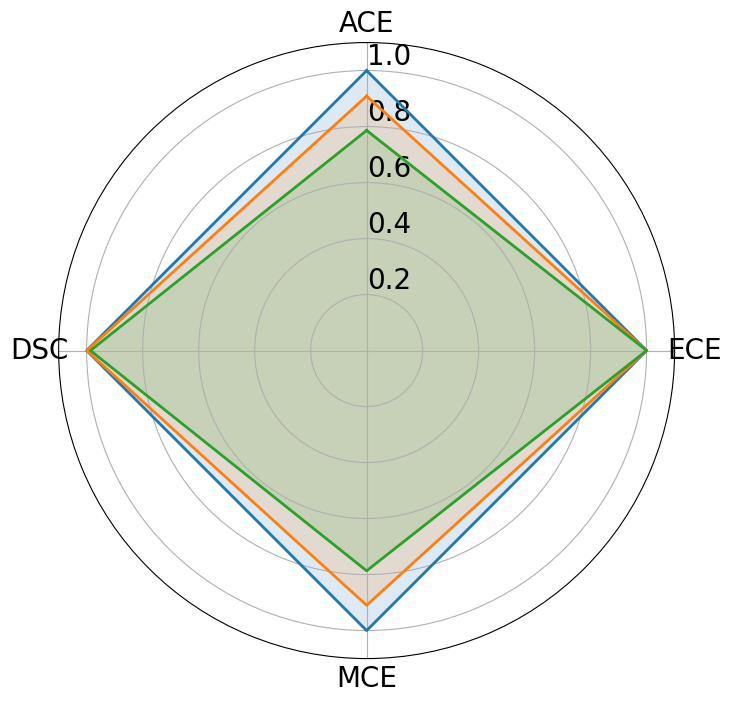

Normalized Spider Plot for liver (MACRO)


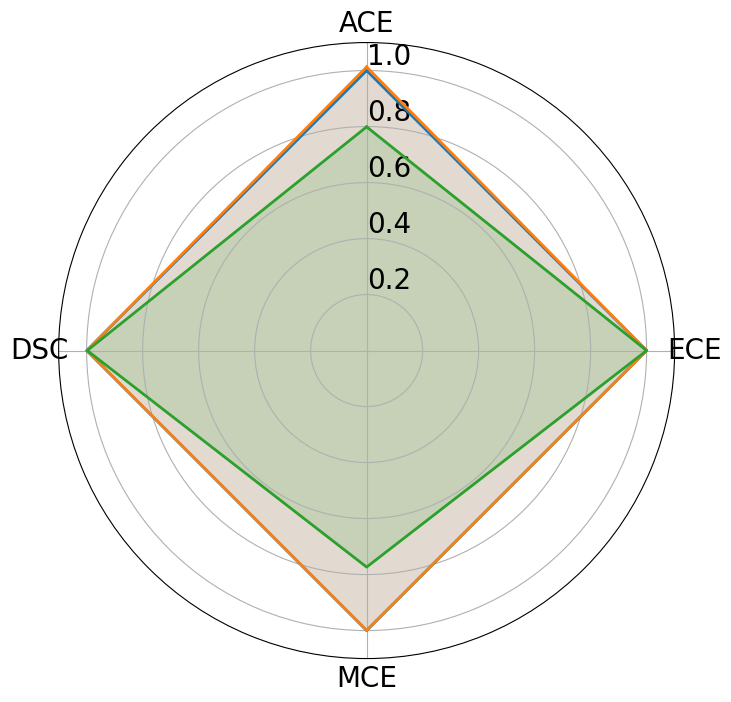

Normalized Spider Plot for stomach (MACRO)


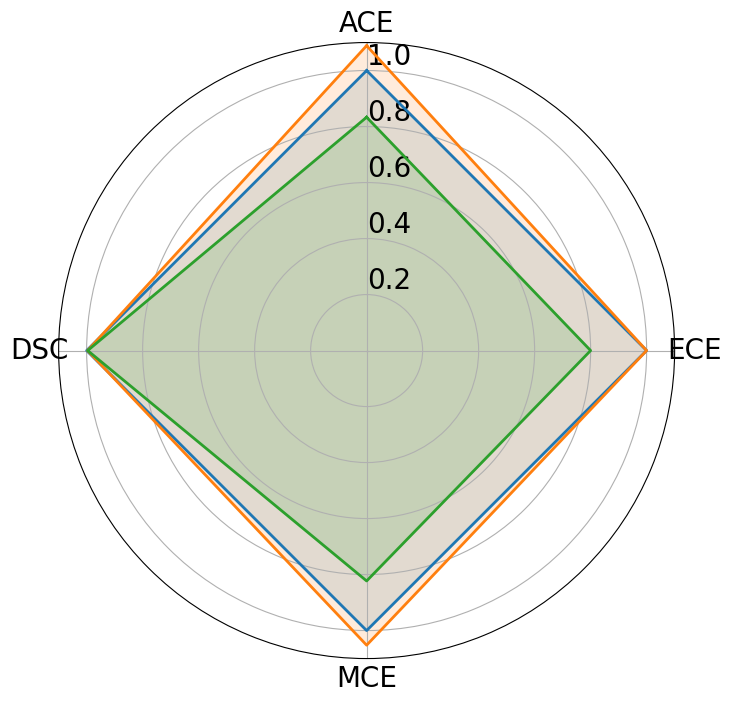

Normalized Spider Plot for aorta (MACRO)


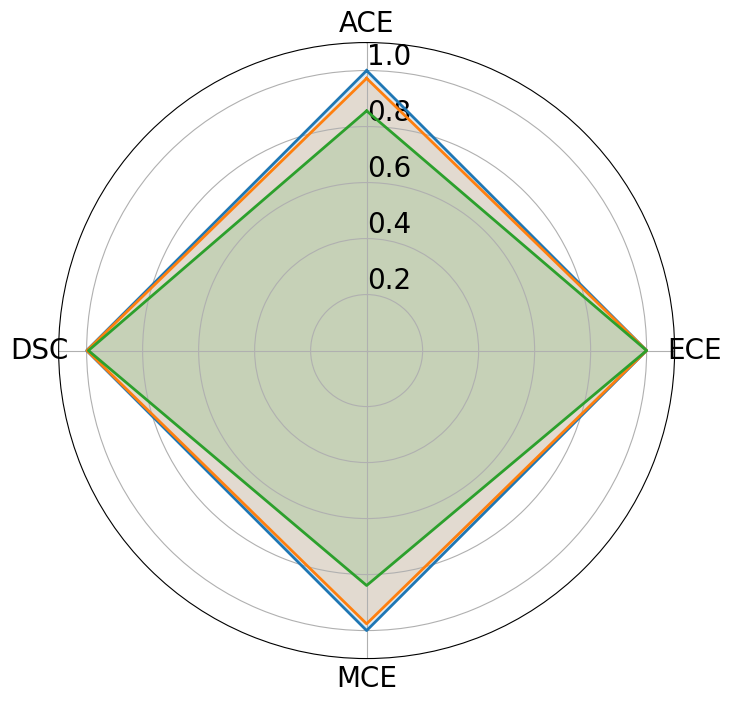

Normalized Spider Plot for inferior_vena_cava (MACRO)


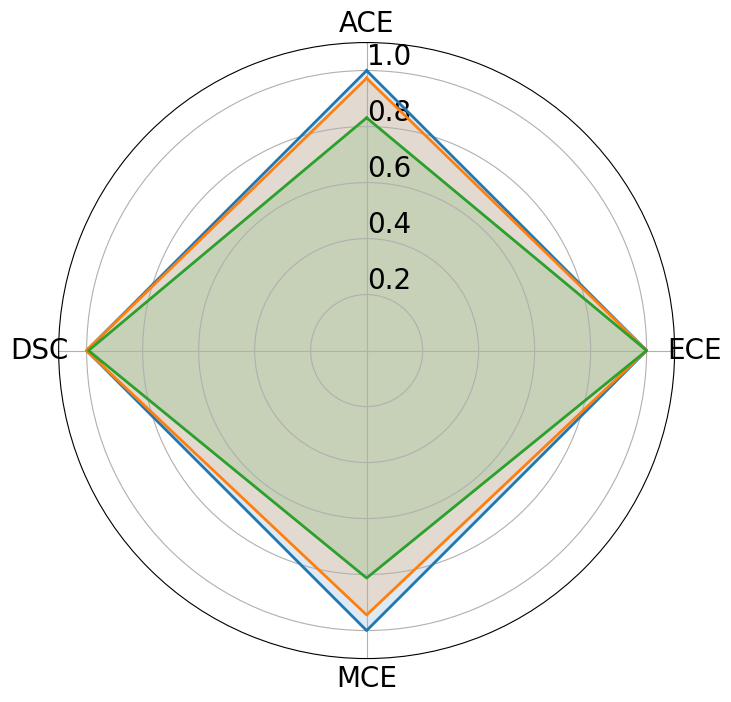

Normalized Spider Plot for pancreas (MACRO)


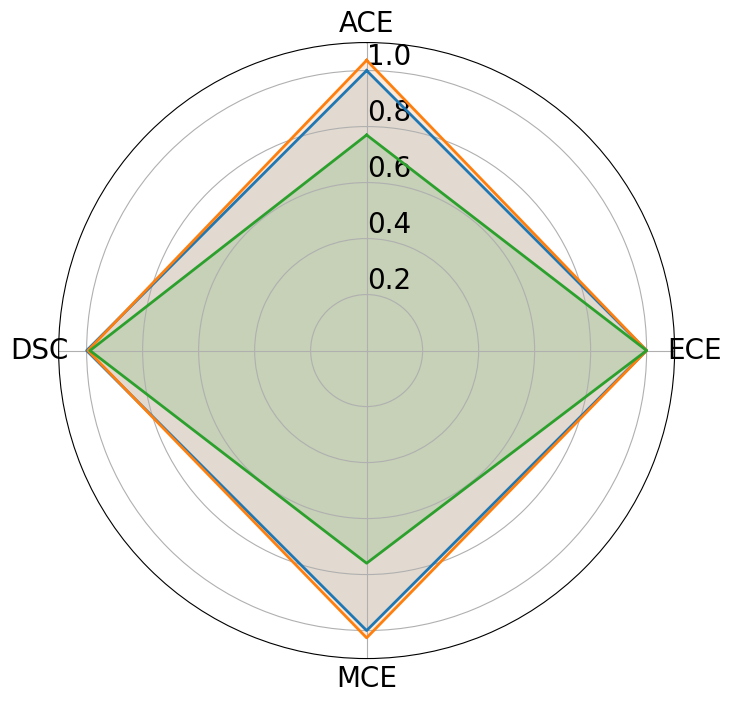

Normalized Spider Plot for right_adrenal_gland (MACRO)


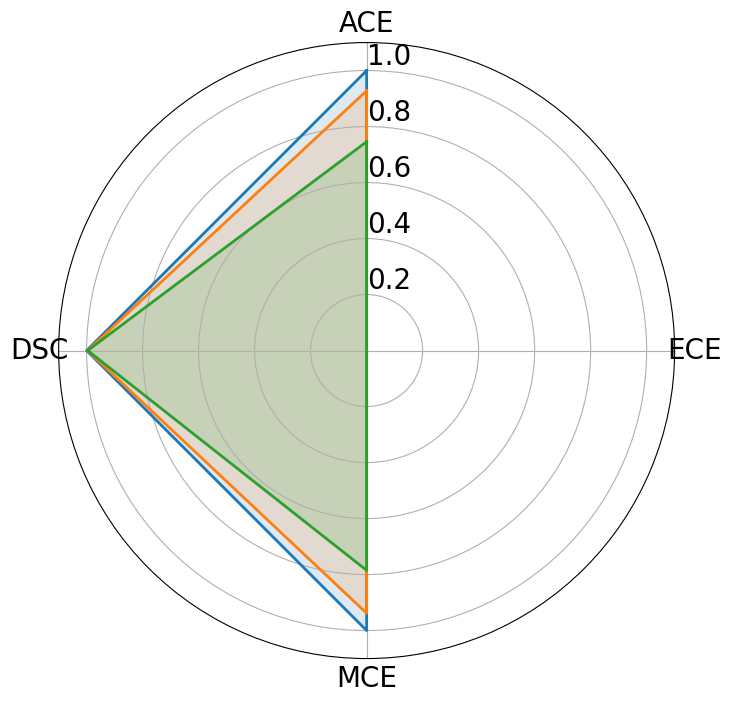

Normalized Spider Plot for left_adrenal_gland (MACRO)


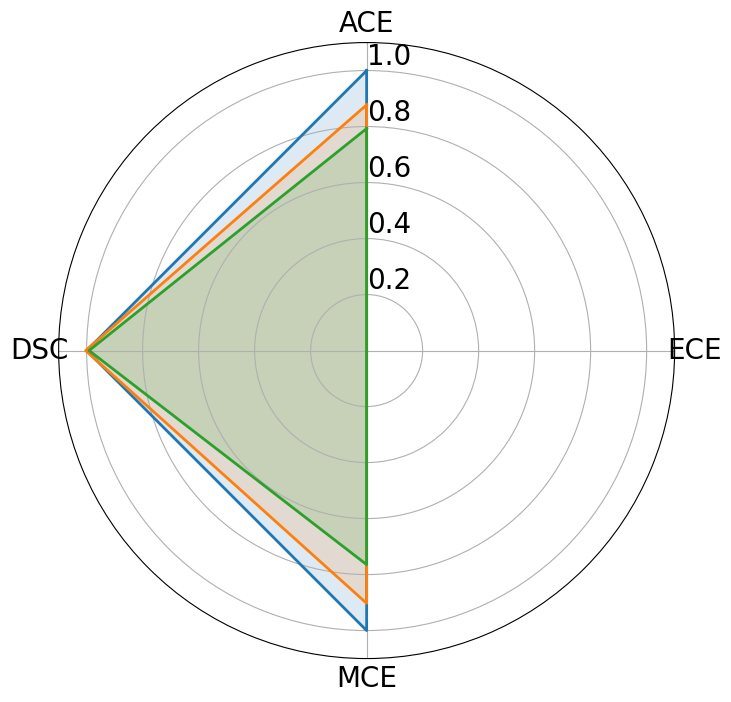

Normalized Spider Plot for duodenum (MACRO)


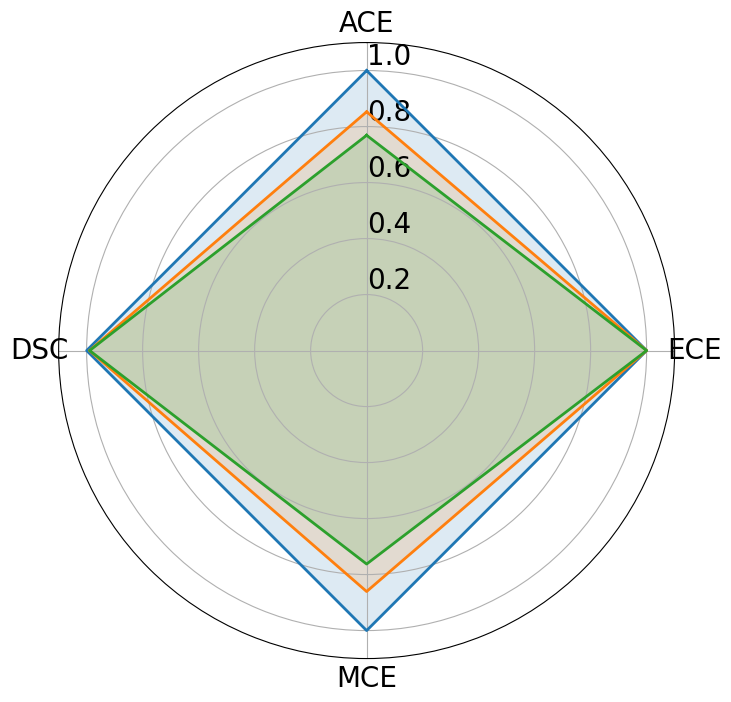

Normalized Spider Plot for bladder (MACRO)


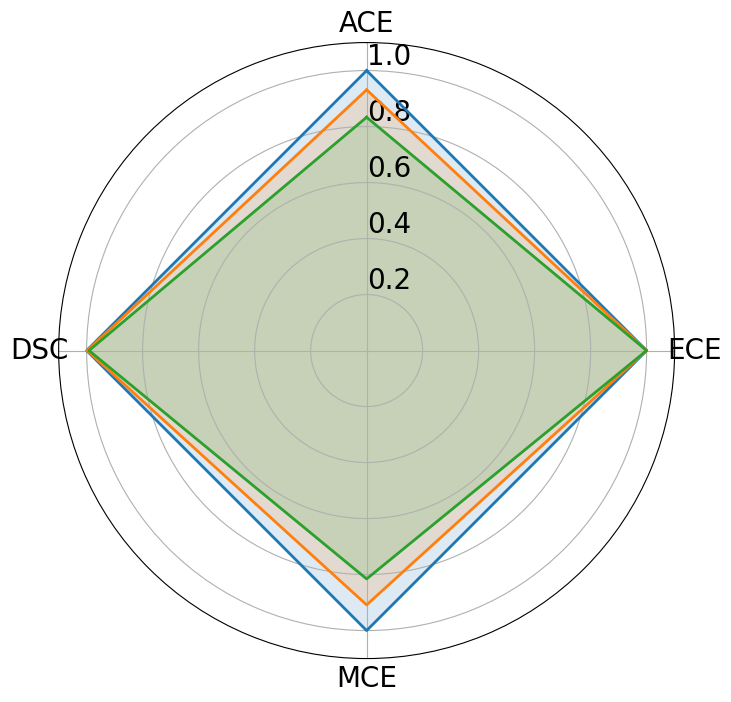

Normalized Spider Plot for prostate or uterus (MACRO)


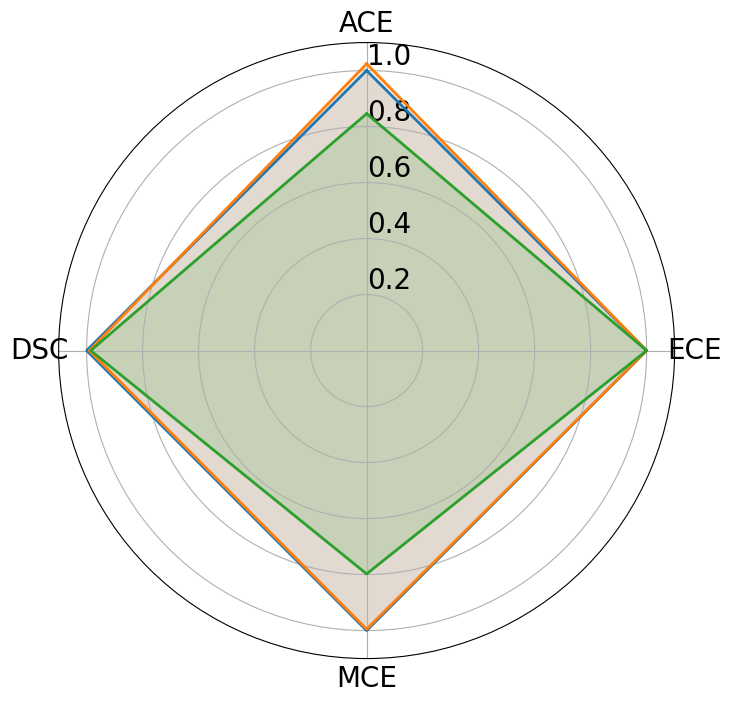

Normalized Spider Plot for spleen (MICRO)


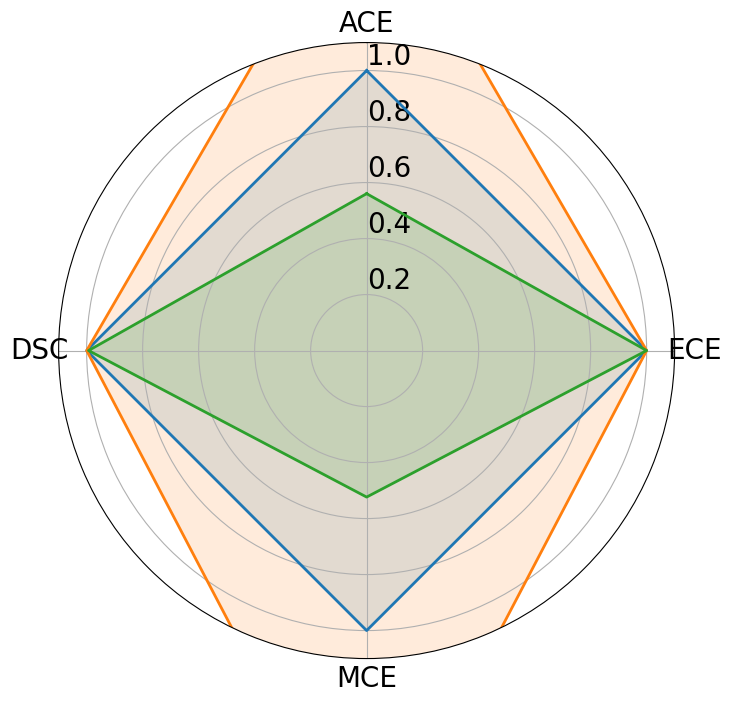

Normalized Spider Plot for right_kidney (MICRO)


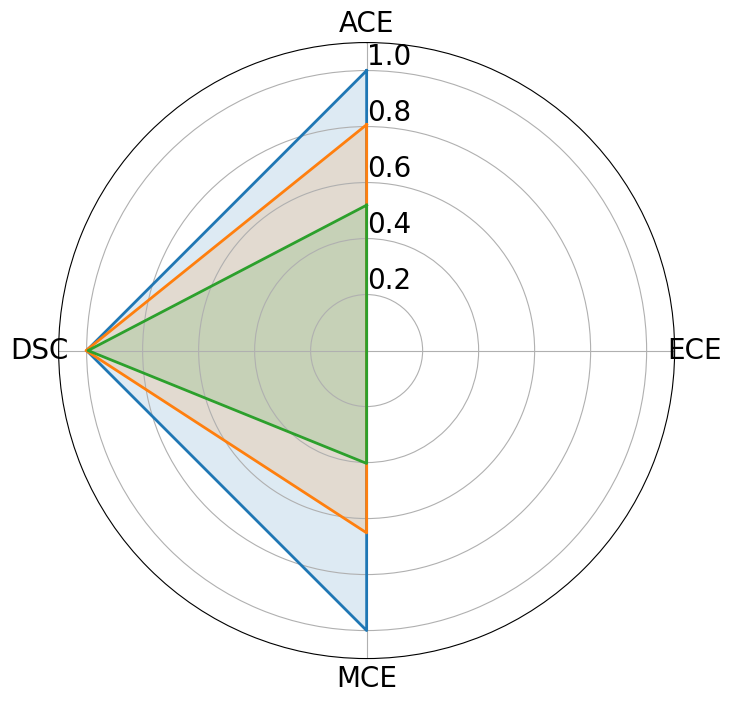

Normalized Spider Plot for left_kidney (MICRO)


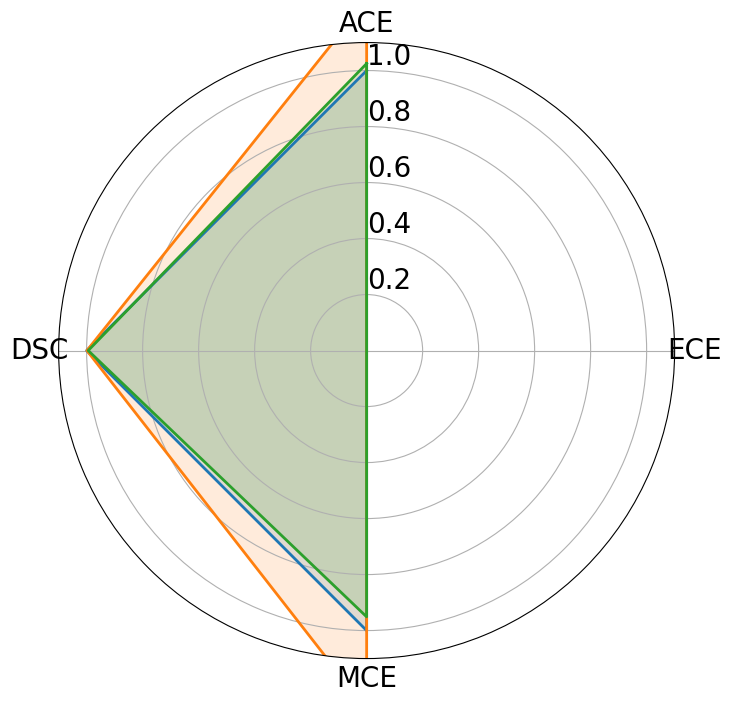

Normalized Spider Plot for gallbladder (MICRO)


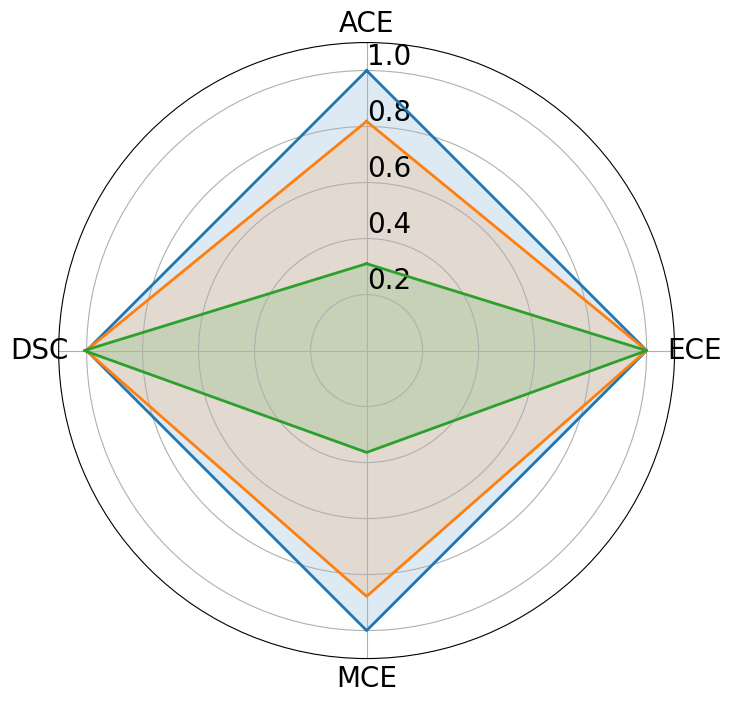

Normalized Spider Plot for esophagus (MICRO)


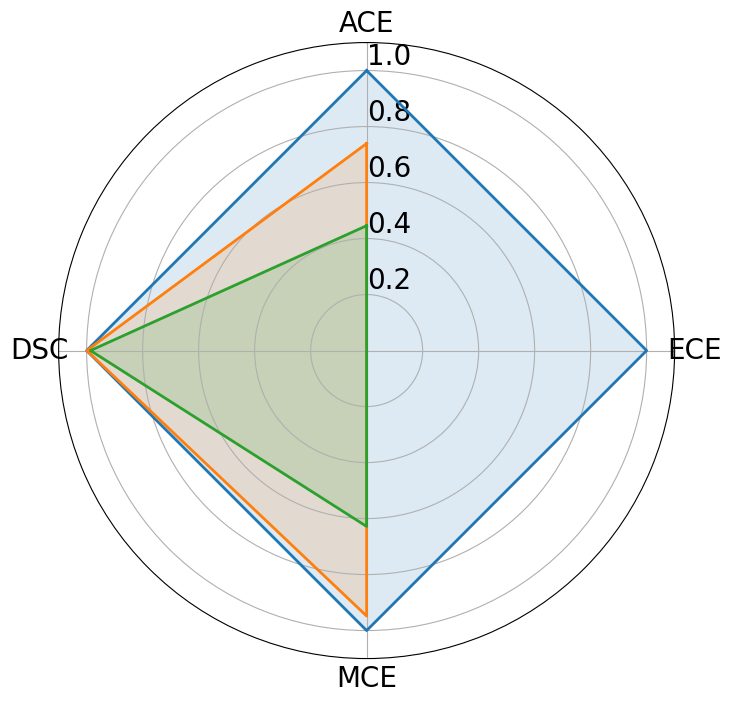

Normalized Spider Plot for liver (MICRO)


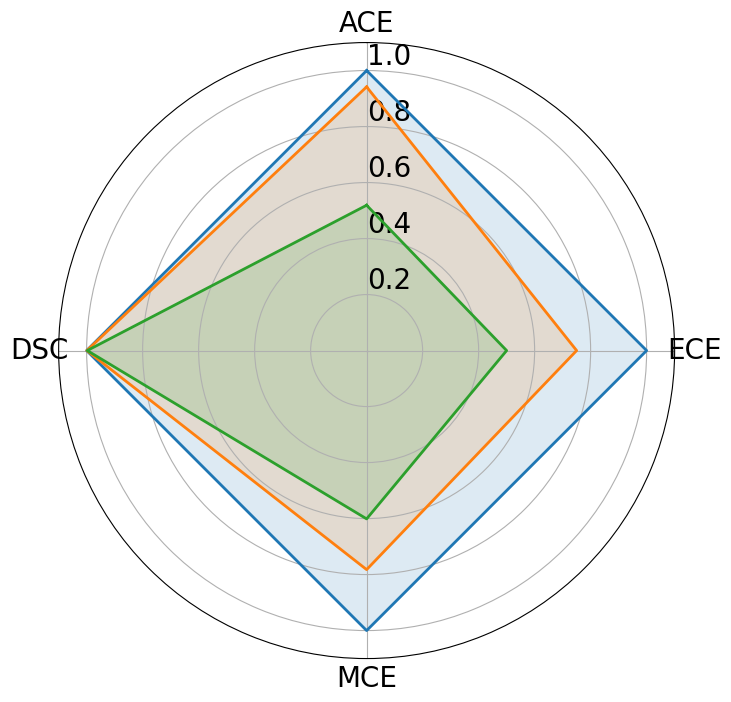

Normalized Spider Plot for stomach (MICRO)


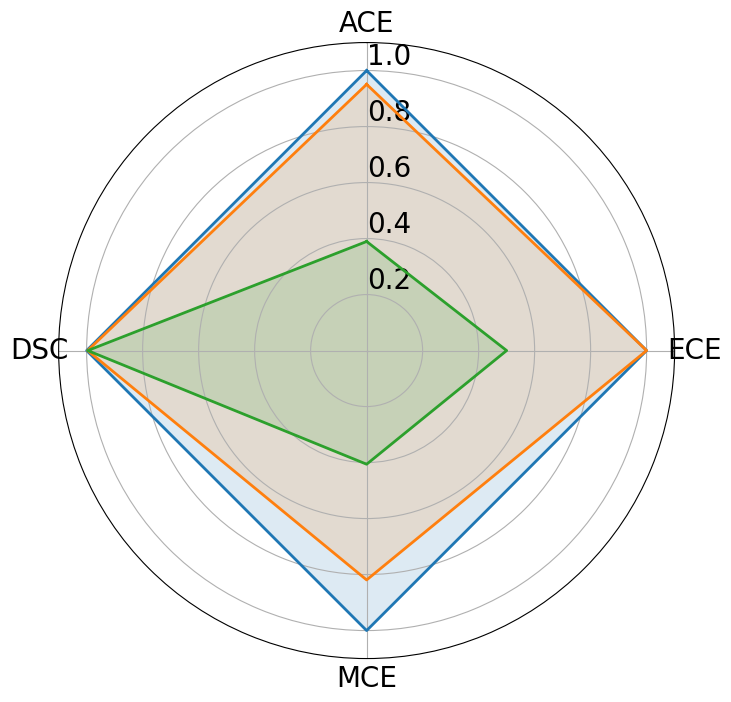

Normalized Spider Plot for aorta (MICRO)


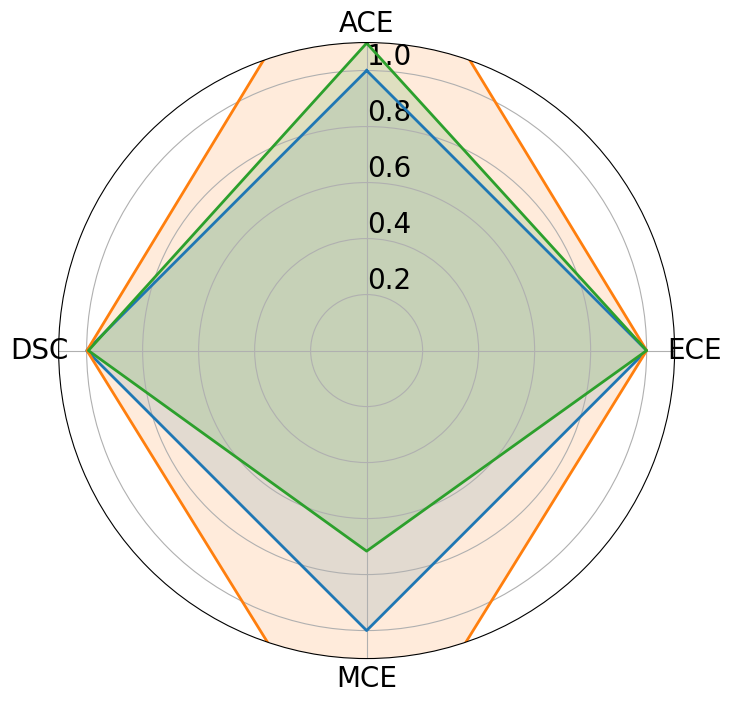

Normalized Spider Plot for inferior_vena_cava (MICRO)


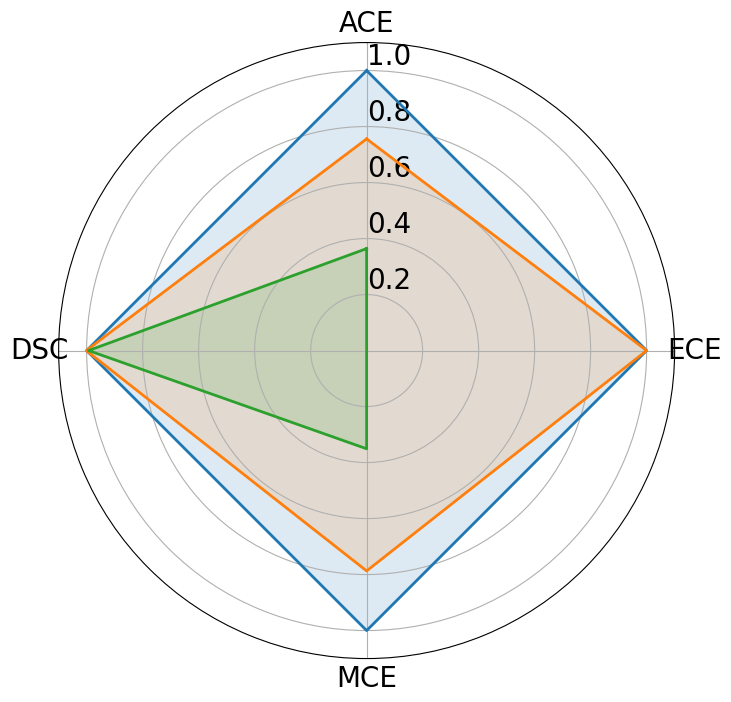

Normalized Spider Plot for pancreas (MICRO)


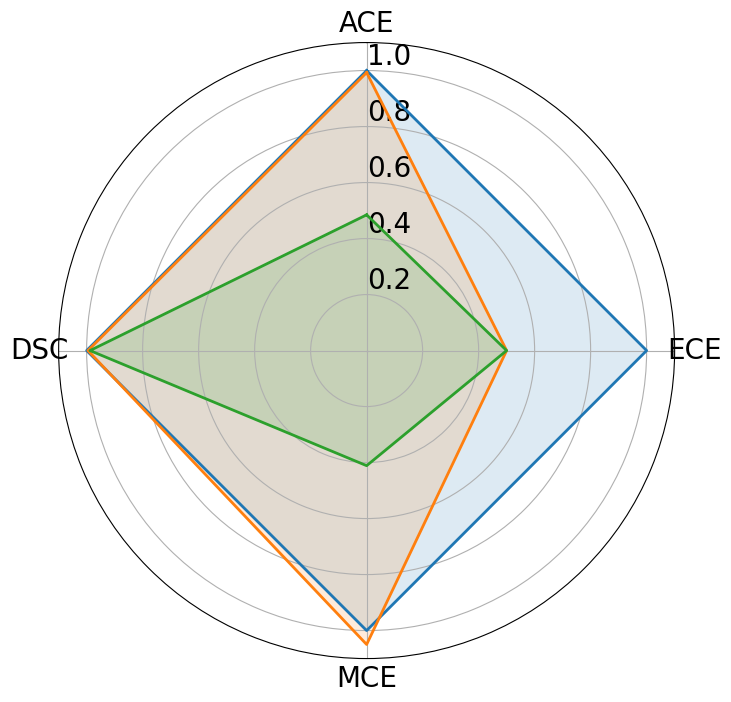

Normalized Spider Plot for right_adrenal_gland (MICRO)


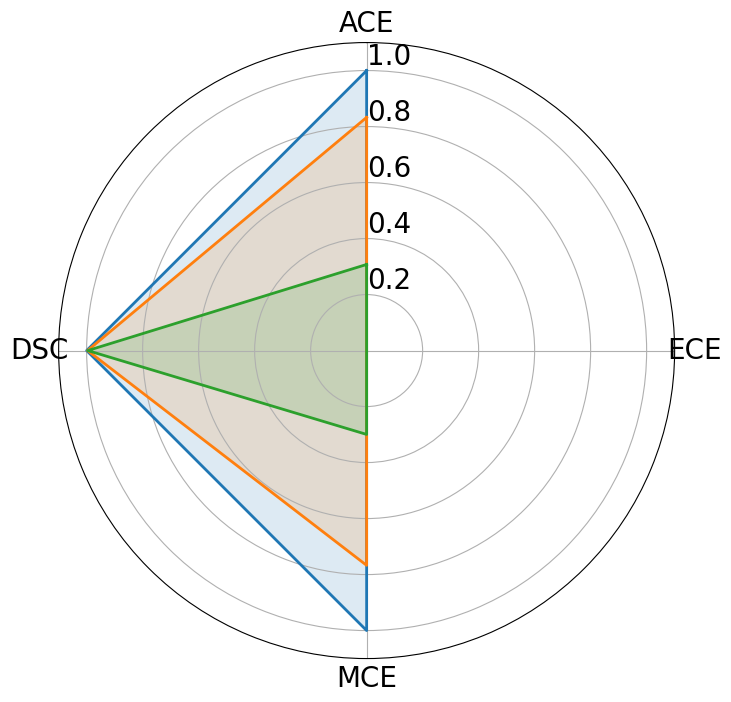

Normalized Spider Plot for left_adrenal_gland (MICRO)


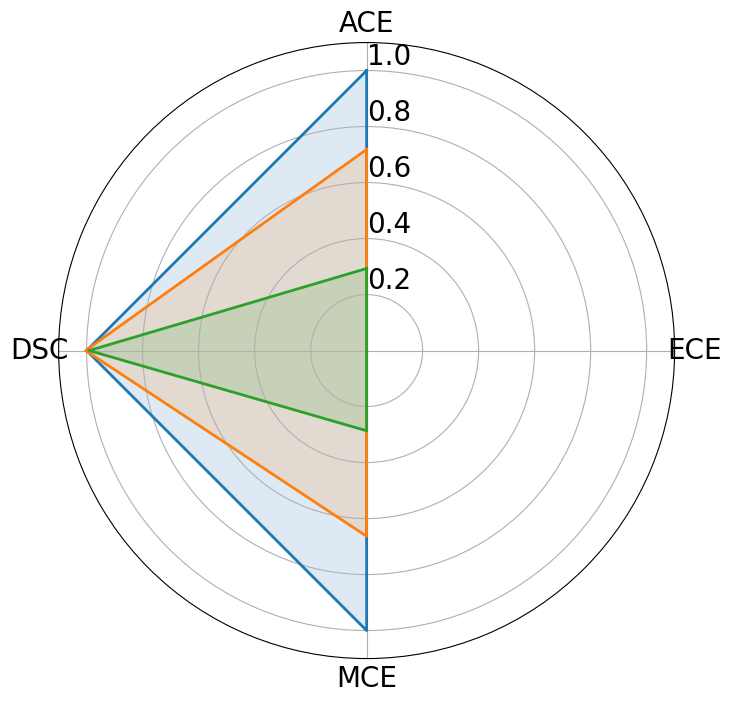

Normalized Spider Plot for duodenum (MICRO)


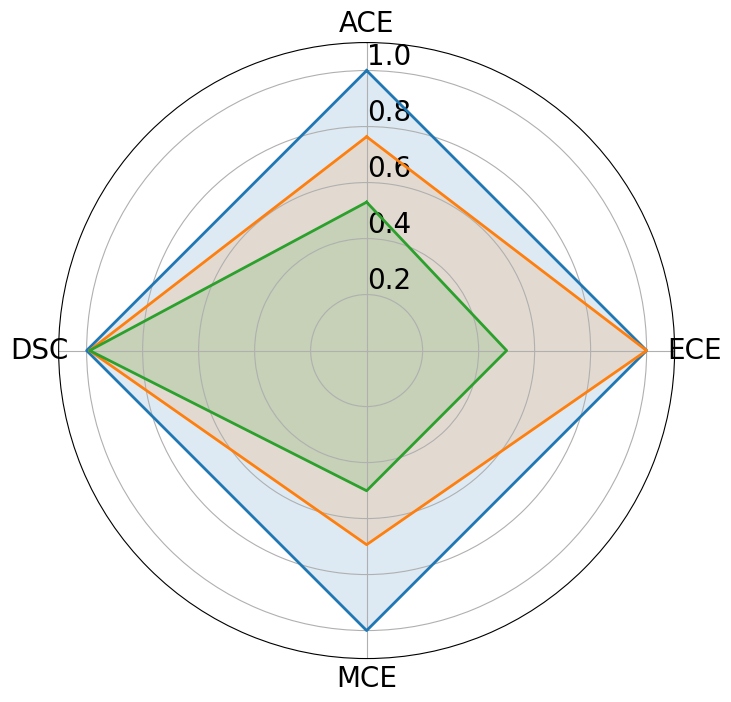

Normalized Spider Plot for bladder (MICRO)


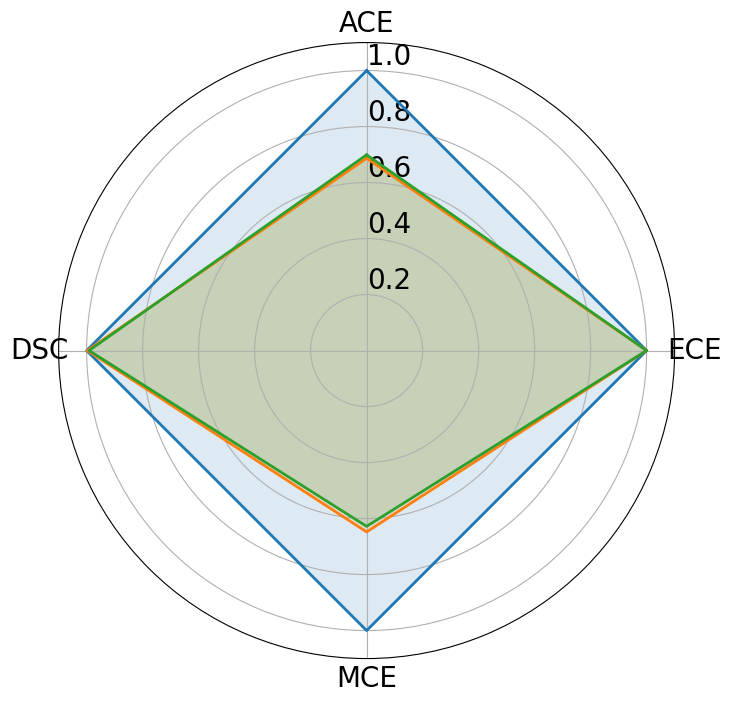

Normalized Spider Plot for prostate or uterus (MICRO)


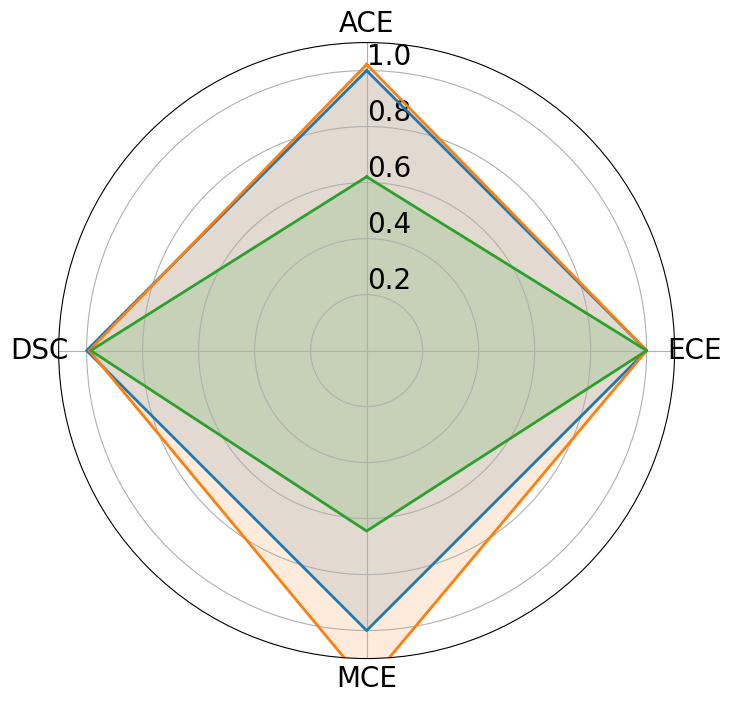

In [72]:
create_class_spider_plot(results, amos_class_names, "amos", avg_type="macro")
create_class_spider_plot(results, amos_class_names, "amos", avg_type="micro")